# UniVI CITE-seq data integration demonstration/tutorial - Subsetting training data by celltype test

Andrew Ashford, Pathways + Omics Group, Oregon Health & Science University - 11/18/2025

This Jupyter Notebook will be used to outline the training steps for a UniVI model using human PBMC CITE-seq data. This is a copy of the other version used to test new code while the other one is running.


#### Import modules

In [1]:
import os, sys, json
import numpy as np
import scanpy as sc
import torch
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler


In [2]:
# -------------------------
# 0. Wire up package import
# -------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from univi import (
    UniVIMultiModalVAE,
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    matching,
)
from univi.data import MultiModalDataset
from univi.trainer import UniVITrainer


#### Read in and preprocess data as needed

In [3]:
# -------------------------
# 2. Load AnnData objects
# -------------------------
# Load RNA AnnData object
rna_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_RNA_data.h5ad")


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [4]:
# Sanity check
print(rna_adata)
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    obsp: 'distances'
  (0, 1)	0.6931471805599453
  (0, 19)	0.6931471805599453
  (0, 23)	0.6931471805599453
  (0, 28)	0.6931471805599453
  (0, 30)	1.3862943611198906
  (0, 48)	0.6931471805599453
  (0, 49)	1.3862943611198906
  (0, 54)	0.6931471805599453
  (0, 57)	1.0986122886681096
  (0, 63)	0.6931471805599453
  (0, 82)	2.1972245773362196
  (0, 98)	0.6931471805599453
  (0, 99)	0.6931471805599453
  (0, 111)	1.791759469228055
  (0, 127)	0.6931471805599453
  (0, 138)	0.6931471805599453
  (0, 149)	0.6931471805599453
  (0, 151)	1.6094379124341003
  (0, 157)	0.6931471805599453
  (0, 159)	0.6931471805599453
  (0, 160)	0

In [5]:
# Change the RNA counts to raw counts so they're not log-normalized and use ZINB or NB as the decoder distribution
# for model training
rna_adata.layers['stored_norm'] = rna_adata.X
rna_adata.layers['counts'] = rna_adata.raw.X
rna_adata.X = rna_adata.layers['counts']


In [6]:
# Norm the RNA data
# Library-size normalize (CPM-ish, per cell)
sc.pp.normalize_total(
    rna_adata,
    target_sum=1e4,    # standard in scRNA
    inplace=True
)   # rna_adata.X becomes normalized counts

# Log-transform (this is your "log1p" expression)
sc.pp.log1p(rna_adata)  # now X = log1p(norm counts)

# Keep a clean copy of log1p-normalized values
rna_adata.layers["log1p"] = rna_adata.X.copy()

print("RNA shape after HVG selection:", rna_adata.shape)


RNA shape after HVG selection: (161764, 20729)


In [7]:
# Sanity check
print(rna_adata.X)
print(rna_adata.X.min())
print(rna_adata.X.max())


  (0, 1)	0.9428929810682248
  (0, 19)	0.9428929810682248
  (0, 23)	0.9428929810682248
  (0, 28)	0.9428929810682248
  (0, 30)	1.7408510757332776
  (0, 48)	0.9428929810682248
  (0, 49)	1.7408510757332776
  (0, 54)	0.9428929810682248
  (0, 57)	1.41943804993247
  (0, 63)	0.9428929810682248
  (0, 82)	2.6055880701758563
  (0, 98)	0.9428929810682248
  (0, 99)	0.9428929810682248
  (0, 111)	2.1789463883292677
  (0, 127)	0.9428929810682248
  (0, 138)	0.9428929810682248
  (0, 149)	0.9428929810682248
  (0, 151)	1.983700234470687
  (0, 157)	0.9428929810682248
  (0, 159)	0.9428929810682248
  (0, 160)	0.9428929810682248
  (0, 161)	0.9428929810682248
  (0, 162)	0.9428929810682248
  (0, 170)	1.41943804993247
  (0, 182)	0.9428929810682248
  :	:
  (161763, 16110)	1.7371448862545538
  (161763, 16113)	1.7371448862545538
  (161763, 16130)	0.7748538943739998
  (161763, 16158)	1.5064800733436712
  (161763, 16159)	1.7371448862545538
  (161763, 16160)	2.338164580793208
  (161763, 16163)	0.7748538943739998
  (16

In [8]:
# If your counts are in rna_adata.X (raw or log-normalized), this is fine:
sc.pp.highly_variable_genes(
    rna_adata,
    layer='log1p',
    n_top_genes=2000,
    flavor="seurat",   # or "cell_ranger" / "seurat_v3"
    inplace=True,
)


In [9]:
# Boolean mask of HVGs
hvg_mask = rna_adata.var["highly_variable"].values

# Names of the top HVGs
hvg_genes = rna_adata.var_names[hvg_mask].tolist()
print(f"Selected {len(hvg_genes)} highly variable genes.")
print(hvg_genes[:20])  # peek at first few


Selected 2000 highly variable genes.
['HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'MIB2', 'MMP23B', 'TNFRSF25', 'CA6', 'RBP7', 'DRAXIN', 'AGTRAP', 'DHRS3', 'PADI4', 'UBXN10-AS1', 'CAMK2N1', 'CDA', 'AL031005.1', 'C1QA', 'C1QC', 'C1QB']


In [10]:
# Optional: make a HVG-only AnnData for modeling
rna_adata_hvg = rna_adata[:, hvg_mask].copy()
print(rna_adata_hvg)


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'log1p', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'stored_norm', 'counts', 'log1p'
    obsp: 'distances'


In [11]:
# Optionally, scale the RNA data
# Z-scale for Gaussian decoder (center per gene, unit variance; clipping to avoid crazy outliers)
sc.pp.scale(
    rna_adata_hvg,
    zero_center=True
    #zero_center=True,
    #max_value=10
)   # rna_adata.X now ~ N(0,1) per gene (on HVGs only)

# Optional: keep a copy of scaled values
rna_adata.layers["scaled"] = rna_adata.X.copy()


In [12]:
# Set rna_adata_hvg.X to Z-scaled values
rna_adata.X = rna_adata.layers["scaled"]


In [13]:
# Load ADT AnnData object
adt_adata = sc.read_h5ad("../data/Hao_CITE-seq_data/Hao_ADT_data.h5ad")


In [14]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
[[1.95916424 0.86914159 1.48523314 ... 0.55307644 1.04608444 1.72565693]
 [0.4322284  1.01422751 0.79594998 ... 0.66587988 0.85514588 1.37971736]
 [0.61381759 1.30390619 0.75610373 ... 0.6874892  0.75610373 1.04246048]
 ...
 [1.50685426 0.54914608 1.0656108  ... 0.25674036 0.25674036 1.16168749]
 [1.63537843 0.32520632 1.19570797 ... 0.45519093 0.51435145 2.10485699]
 [1.58503    0.64458811 1.61118685 ... 0.416905   0.23002318 2.07731277]]
0.0
8.589231339100166


In [18]:
# Set the ADT data to raw counts and use a NB or ZINB decoder in model training and save the current .X counts to
# .layers['log1p']
adt_adata.layers['stored_norm'] = adt_adata.X
adt_adata.layers['counts'] = adt_adata.raw.X
adt_adata.X = adt_adata.layers['counts']


In [20]:
# Normalize and optionally scale ADT data using CLR norming
# --------------------------------------------------
# ADT: CLR normalize from raw counts
#   - raw counts in adt_adata.layers['counts'] and in .X
#   - Hao-normalized values currently in adt_adata.layers['stored_norm']
# --------------------------------------------------

# log1p
#X_log = np.log1p(adt_adata)

#import scanpy as sc

sc.pp.log1p(adt_adata)  # modifies adt_adata.X


In [22]:
X_log = adt_adata.X


In [24]:
# CLR: subtract per-cell mean log expression (equivalent to ln( count_ij / geometric_mean_i ))
row_means = X_log.mean(axis=1)
X_clr = X_log - row_means


In [25]:
# Store CLR in layers and set as current X
adt_adata.layers["clr"] = X_clr
adt_adata.X = X_clr.copy()

print("ADT CLR shape:", adt_adata.shape)


ADT CLR shape: (161764, 228)


In [26]:
# --------------------------------------------------
# Optional: Z-scale CLR values for Gaussian decoder
#   (per-protein mean 0, var 1 across cells)
#   If you stick with Gaussian decoders for ADT too, DO this.
#   If you use NB/ZINB for ADT, DON'T.
# --------------------------------------------------
scaler_adt = StandardScaler(with_mean=True, with_std=True)
X_clr_scaled = scaler_adt.fit_transform(X_clr)

adt_adata.layers["clr_scaled"] = X_clr_scaled
adt_adata.X = X_clr_scaled
print("ADT CLR scaled for Gaussian decoder, shape:", adt_adata.X.shape)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


ADT CLR scaled for Gaussian decoder, shape: (161764, 228)


In [27]:
# Sanity check
print(adt_adata)
print(adt_adata.X)
print(adt_adata.X.min())
print(adt_adata.X.max())


AnnData object with n_obs × n_vars = 161764 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features'
    uns: 'log1p'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'stored_norm', 'counts', 'clr', 'clr_scaled'
[[ 1.75353838  0.63154435  0.77162124 ... -0.30293594  1.15547398
   0.79655139]
 [-0.69662312  1.12293289 -0.95481186 ...  0.24935615  0.62156007
   0.27990605]
 [-0.27562413  1.91766876 -1.06597148 ...  0.34149149  0.30626632
  -0.28328269]
 ...
 [ 1.17244265 -0.40020108 -0.20187065 ... -1.64015216 -1.83246206
  -0.07285185]
 [ 1.33230182 -1.59675792  0.08586175 ... -0.74620268 -0.70590279
   1.34267206]
 [ 1.27350976 -0.07507278  1.07045903 ... -0.82878852 -2.08149672
   1.30990852]]
-9.157326331250525
15.32049290481086


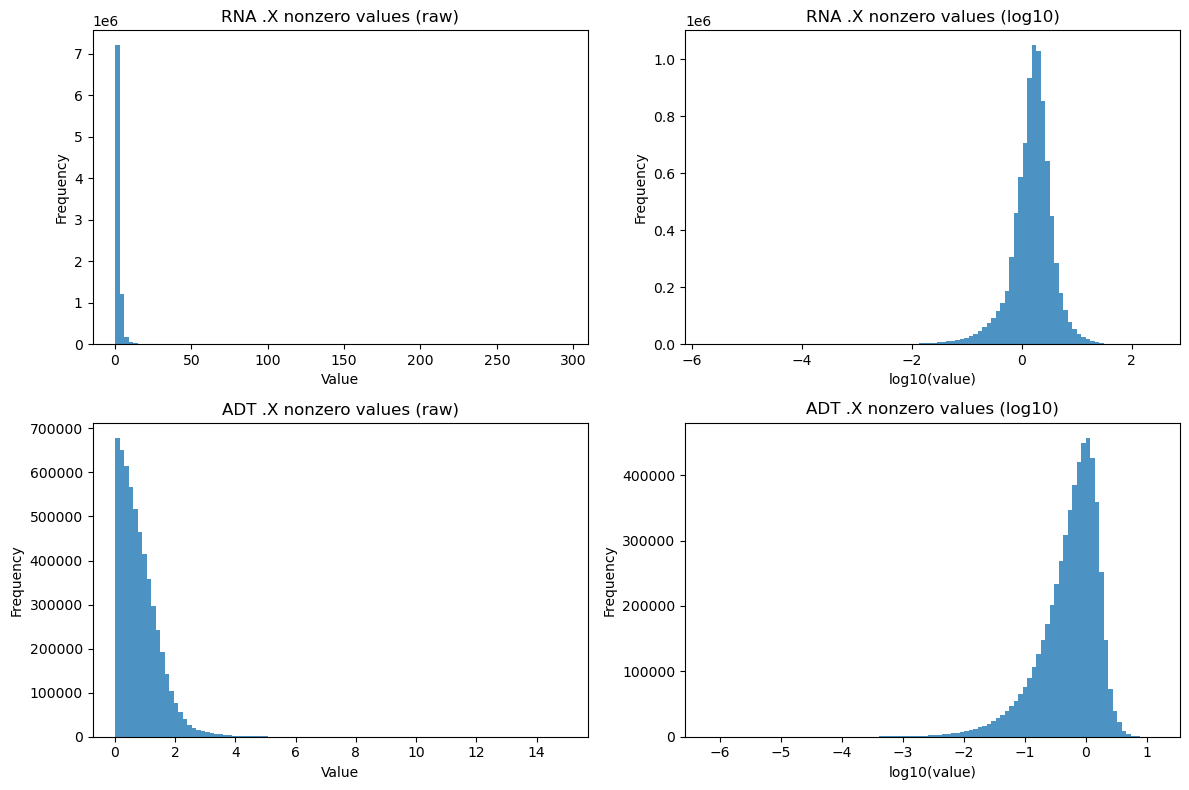

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

def get_X_values(adata, n_cells: int = 5000):
    """
    Return flattened values from adata.X (optionally subsampled over cells).
    Uses only non-zero entries if X is sparse.
    """
    X = adata.X

    # Optional subsampling over cells (rows)
    if n_cells is not None and adata.n_obs > n_cells:
        idx = np.random.choice(adata.n_obs, size=n_cells, replace=False)
        X = X[idx]

    if sparse.issparse(X):
        vals = X.data  # nonzero values
    else:
        vals = np.asarray(X).ravel()

    # Remove zeros explicitly (just to focus on count/ADT magnitude)
    vals = vals[vals > 0]
    return vals

def plot_X_distribution(rna_adata, adt_adata, n_cells: int = 5000):
    rna_vals = get_X_values(rna_adata, n_cells=n_cells)
    adt_vals = get_X_values(adt_adata, n_cells=n_cells)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # --- RNA raw ---
    axes[0, 0].hist(rna_vals, bins=100, alpha=0.8)
    axes[0, 0].set_title("RNA .X nonzero values (raw)")
    axes[0, 0].set_xlabel("Value")
    axes[0, 0].set_ylabel("Frequency")

    # --- RNA log10 ---
    axes[0, 1].hist(np.log10(rna_vals + 1e-8), bins=100, alpha=0.8)
    axes[0, 1].set_title("RNA .X nonzero values (log10)")
    axes[0, 1].set_xlabel("log10(value)")
    axes[0, 1].set_ylabel("Frequency")

    # --- ADT raw ---
    axes[1, 0].hist(adt_vals, bins=100, alpha=0.8)
    axes[1, 0].set_title("ADT .X nonzero values (raw)")
    axes[1, 0].set_xlabel("Value")
    axes[1, 0].set_ylabel("Frequency")

    # --- ADT log10 ---
    axes[1, 1].hist(np.log10(adt_vals + 1e-8), bins=100, alpha=0.8)
    axes[1, 1].set_title("ADT .X nonzero values (log10)")
    axes[1, 1].set_xlabel("log10(value)")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Call it:
plot_X_distribution(rna_adata_hvg, adt_adata, n_cells=50000)


In [29]:
print(rna_adata_hvg)
print(set(rna_adata_hvg.obs['celltype.l1']))
print(rna_adata_hvg.obs['celltype.l1'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l2']))
print(rna_adata_hvg.obs['celltype.l2'].value_counts())
print(set(rna_adata_hvg.obs['celltype.l3']))
print(rna_adata_hvg.obs['celltype.l3'].value_counts())


AnnData object with n_obs × n_vars = 161764 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'neighbors', 'log1p', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'stored_norm', 'counts', 'log1p'
    obsp: 'distances'
{'other', 'DC', 'B', 'Mono', 'NK', 'CD8 T', 'other T', 'CD4 T'}
Mono       49010
CD4 T      41001
CD8 T      25469
NK         18664
B          13800
other T     6789
DC          3589
other       3442
Name: celltype.l1, dtype: int64
{'B naive', 'cDC2', 'B memory', 'Treg', 'MAIT', 'dnT', 'B intermediate', 'Eryth', 'CD4 Proliferating', 'CD16 Mono', 'gdT', 'CD8 Proliferating', 'CD8 TCM', 'CD4 TCM', 'CD4 TEM', 'pDC', 'NK', 'NK_CD56bright', 'HSPC', 'CD4 Naive',

#### Initialize model and data via dataloaders

In [30]:
import json
from univi.config import ModalityConfig, UniVIConfig, TrainingConfig

# -------------------------
# 1. Load JSON
# -------------------------
with open("../parameter_files/defaults_cite_seq.json") as f:
    cfg_json = json.load(f)

data_cfg  = cfg_json["data"]
model_cfg = cfg_json["model"]
train_cfg_json = cfg_json["training"]

# -------------------------
# 2. Build ModalityConfig list
# -------------------------
adata_by_mod = {
    "rna": rna_adata_hvg,   # make sure these exist
    "adt": adt_adata,
}

modality_cfgs = []
for m in data_cfg["modalities"]:
    name = m["name"]
    if name not in adata_by_mod:
        raise ValueError(f"Modality '{name}' not found in adata_by_mod")

    adata = adata_by_mod[name]
    hidden = m.get("hidden_dims", model_cfg["hidden_dims_default"])

    mc = ModalityConfig(
        name=name,
        input_dim=int(adata.n_vars),
        encoder_hidden=hidden,
        decoder_hidden=hidden,
        likelihood=m["likelihood"],   # "nb", "gaussian", "zinb", etc.
    )
    modality_cfgs.append(mc)

print("Built ModalityConfig list:")
for mc in modality_cfgs:
    print(" ", mc)

assert len(modality_cfgs) > 0, "No modalities found for UniVIConfig!"

# -------------------------
# 3. UniVIConfig
# -------------------------
univi_cfg = UniVIConfig(
    latent_dim=model_cfg["latent_dim"],
    modalities=modality_cfgs,
    beta=model_cfg["beta"],
    gamma=model_cfg["gamma"],
    encoder_dropout=model_cfg.get("dropout", 0.0),
    encoder_batchnorm=model_cfg.get("batchnorm", True),
    kl_anneal_start=model_cfg.get("kl_anneal_start", 0),
    kl_anneal_end=model_cfg.get("kl_anneal_end", 0),
    align_anneal_start=model_cfg.get("align_anneal_start", 0),
    align_anneal_end=model_cfg.get("align_anneal_end", 0),
)

print("UniVIConfig:", univi_cfg)

# -------------------------
# 4. TrainingConfig
# -------------------------
train_cfg = TrainingConfig(
    n_epochs=train_cfg_json["n_epochs"],
    batch_size=train_cfg_json["batch_size"],
    lr=train_cfg_json["lr"],
    weight_decay=train_cfg_json.get("weight_decay", 0.0),
    device=train_cfg_json.get("device", "cpu"),  # use "cpu" if no CUDA
    log_every=train_cfg_json.get("log_every", 10),
    grad_clip=train_cfg_json.get("grad_clip", None),
    num_workers=train_cfg_json.get("num_workers", 0),
    seed=train_cfg_json.get("seed", 0),
    early_stopping=train_cfg_json.get("early_stopping", True),
    patience=train_cfg_json.get("patience", 20),
    min_delta=train_cfg_json.get("min_delta", 0.0),
)

print("TrainingConfig:", train_cfg)


Built ModalityConfig list:
  ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='gaussian')
  ModalityConfig(name='adt', input_dim=228, encoder_hidden=[256, 128], decoder_hidden=[256, 128], likelihood='gaussian')
UniVIConfig: UniVIConfig(latent_dim=40, modalities=[ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='gaussian'), ModalityConfig(name='adt', input_dim=228, encoder_hidden=[256, 128], decoder_hidden=[256, 128], likelihood='gaussian')], beta=100.0, gamma=120.0, encoder_dropout=0.1, decoder_dropout=0.0, encoder_batchnorm=True, decoder_batchnorm=False, kl_anneal_start=5, kl_anneal_end=45, align_anneal_start=5, align_anneal_end=45)
TrainingConfig: TrainingConfig(n_epochs=200, batch_size=256, lr=0.001, weight_decay=0.0001, device='cpu', log_every=10, grad_clip=5.0, num_workers=0, seed=42, early_stopping=True, patience=20, min_delta=0.0)


In [31]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from univi.data import MultiModalDataset

# --------------------------------------------------
# 0. Sanity check: RNA / ADT are already aligned
# --------------------------------------------------
assert rna_adata_hvg.n_obs == adt_adata.n_obs, "RNA and ADT have different #cells"
assert np.array_equal(rna_adata_hvg.obs_names, adt_adata.obs_names), (
    "RNA and ADT obs_names are not aligned – align them first."
)

print(f"Total paired cells BEFORE subsampling: {rna_adata_hvg.n_obs}")

# --------------------------------------------------
# 1. Per-celltype subsampling for balance
# --------------------------------------------------
celltype_key = "celltype.l1"
max_per_type = 2000

labels = rna_adata_hvg.obs[celltype_key].astype(str).values
unique_ct = np.unique(labels)

rng = np.random.default_rng(train_cfg.seed)

selected_indices_list = []
for ct in unique_ct:
    idx_ct = np.where(labels == ct)[0]
    if len(idx_ct) == 0:
        continue
    if len(idx_ct) > max_per_type:
        chosen = rng.choice(idx_ct, size=max_per_type, replace=False)
    else:
        chosen = idx_ct
    selected_indices_list.append(chosen)

selected_indices = np.concatenate(selected_indices_list)
rng.shuffle(selected_indices)

n_cells = len(selected_indices)
print(f"Total paired cells AFTER per-celltype cap: {n_cells}")

# --------------------------------------------------
# 2. Build MultiModalDataset (full, indices will subset)
# --------------------------------------------------
adata_by_mod = {"rna": rna_adata_hvg, "adt": adt_adata}

full_dataset = MultiModalDataset(
    adata_dict=adata_by_mod,
    X_key="X",                # or your desired layer/key
    device=train_cfg.device,
)

# --------------------------------------------------
# 3. Train / val / test splits on selected_indices
# --------------------------------------------------
frac_train = 0.8
frac_val   = 0.1

n_train = int(frac_train * n_cells)
n_val   = int(frac_val   * n_cells)

train_idx = selected_indices[:n_train]
val_idx   = selected_indices[n_train:n_train + n_val]
test_idx  = selected_indices[n_train + n_val:]

print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)
test_dataset  = Subset(full_dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=True,
    num_workers=train_cfg.num_workers,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=train_cfg.batch_size,
    shuffle=False,
    num_workers=train_cfg.num_workers,
)

# --------------------------------------------------
# 4. Mark splits + unused cells for later reference
#    (CRITICAL: use rna_adata_hvg, not rna_adata)
# --------------------------------------------------
def init_split_column(adata, col="univi_split"):
    if col not in adata.obs.columns:
        adata.obs[col] = "unused"
    else:
        adata.obs[col] = "unused"

# mark on HVG RNA and on ADT
init_split_column(rna_adata_hvg, "univi_split")
init_split_column(adt_adata,     "univi_split")

# start everything as unused
rna_adata_hvg.obs["univi_split"] = "unused"
adt_adata.obs["univi_split"]     = "unused"

# mark train / val / test by positional indices
rna_adata_hvg.obs.iloc[train_idx, rna_adata_hvg.obs.columns.get_loc("univi_split")] = "train"
rna_adata_hvg.obs.iloc[val_idx,   rna_adata_hvg.obs.columns.get_loc("univi_split")] = "val"
rna_adata_hvg.obs.iloc[test_idx,  rna_adata_hvg.obs.columns.get_loc("univi_split")] = "test"

adt_adata.obs.iloc[train_idx, adt_adata.obs.columns.get_loc("univi_split")] = "train"
adt_adata.obs.iloc[val_idx,   adt_adata.obs.columns.get_loc("univi_split")] = "val"
adt_adata.obs.iloc[test_idx,  adt_adata.obs.columns.get_loc("univi_split")] = "test"

# split AnnData *in the same feature space UniVI was trained on*
rna_train_adata = rna_adata_hvg[rna_adata_hvg.obs["univi_split"] == "train"].copy()
rna_val_adata   = rna_adata_hvg[rna_adata_hvg.obs["univi_split"] == "val"].copy()
rna_test_adata  = rna_adata_hvg[rna_adata_hvg.obs["univi_split"] == "test"].copy()
rna_unused      = rna_adata_hvg[rna_adata_hvg.obs["univi_split"] == "unused"].copy()

adt_train_adata = adt_adata[adt_adata.obs["univi_split"] == "train"].copy()
adt_val_adata   = adt_adata[adt_adata.obs["univi_split"] == "val"].copy()
adt_test_adata  = adt_adata[adt_adata.obs["univi_split"] == "test"].copy()
adt_unused      = adt_adata[adt_adata.obs["univi_split"] == "unused"].copy()

print(
    "RNA (HVG) split sizes:",
    {k: v.n_obs for k, v in dict(
        train=rna_train_adata,
        val=rna_val_adata,
        test=rna_test_adata,
        unused=rna_unused,
    ).items()},
)

print(
    "ADT split sizes:",
    {k: v.n_obs for k, v in dict(
        train=adt_train_adata,
        val=adt_val_adata,
        test=adt_test_adata,
        unused=adt_unused,
    ).items()},
)


Total paired cells BEFORE subsampling: 161764
Total paired cells AFTER per-celltype cap: 16000
Train: 12800, Val: 1600, Test: 1600
RNA (HVG) split sizes: {'train': 12800, 'val': 1600, 'test': 1600, 'unused': 145764}
ADT split sizes: {'train': 12800, 'val': 1600, 'test': 1600, 'unused': 145764}


In [32]:
for_rna_umap = rna_test_adata.copy()
for_adt_umap = adt_test_adata.copy()


In [36]:
print(for_rna_umap)
print(for_rna_umap.X.min())
print(for_rna_umap.X.max())

for_rna_umap.layers['scaled'] = for_rna_umap.X


AnnData object with n_obs × n_vars = 1600 × 2000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'univi_split'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'neighbors', 'log1p', 'hvg'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'stored_norm', 'counts', 'log1p'
    obsp: 'distances'
-9.133895747123823
252.9908995727017


In [37]:
# =========================
# 1) RNA: UMAP from rna_adata.hvg.layers['log1p']
# =========================

print("RNA shape:", for_rna_umap.shape)

# Shallow copy for PCA so we don't mess with the original X
rna_pca = for_rna_umap.copy()

# Use the scaled log1p layer as X for PCA
rna_pca.X = for_rna_umap.layers["scaled"].copy()

# Run PCA
sc.tl.pca(rna_pca, n_comps=50)

# Store PCA back on the HVG object
for_rna_umap.obsm["X_pca"] = rna_pca.obsm["X_pca"]
for_rna_umap.varm["PCs"]   = rna_pca.varm["PCs"]

# ---- clear neighbors from previous attempts ----
for k in ["neighbors"]:
    if k in for_rna_umap.uns:
        del for_rna_umap.uns[k]

for k in ["distances", "connectivities"]:
    if k in for_rna_umap.obsp:
        del for_rna_umap.obsp[k]

# ---- recompute neighbors / UMAP ----
sc.pp.neighbors(
    for_rna_umap,
    use_rep="X_pca",    # use your PCA
    n_neighbors=30,     # neighbors (NOT n_pcs)
    metric="cosine",    # common for scRNA
)

sc.tl.umap(for_rna_umap)


RNA shape: (1600, 2000)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


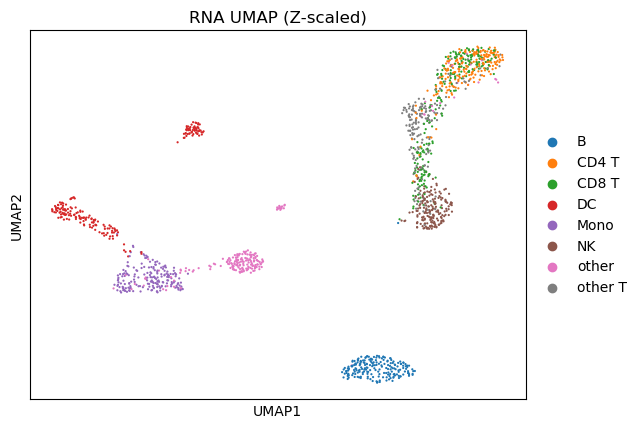

In [38]:
sc.pl.umap(
    for_rna_umap,
    color="celltype.l1",  # or whatever key you want
    size=10,
    title="RNA UMAP (Z-scaled)",
)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


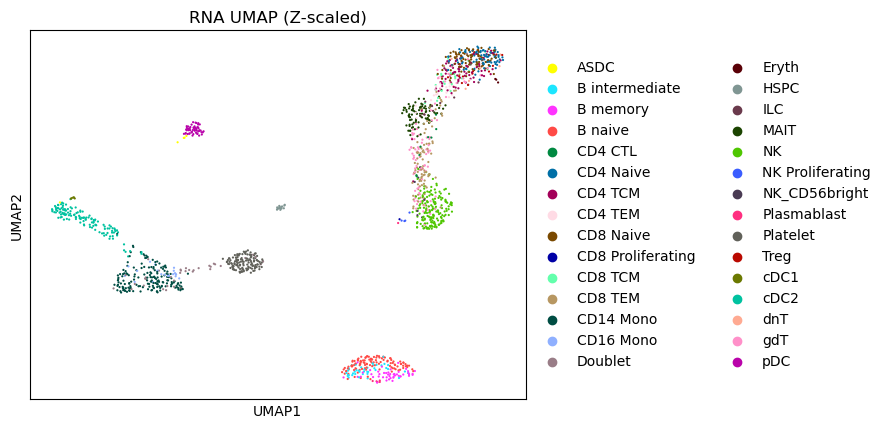

In [39]:
sc.pl.umap(
    for_rna_umap,
    color="celltype.l2",  # or whatever key you want
    size=10,
    title="RNA UMAP (Z-scaled)",
)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


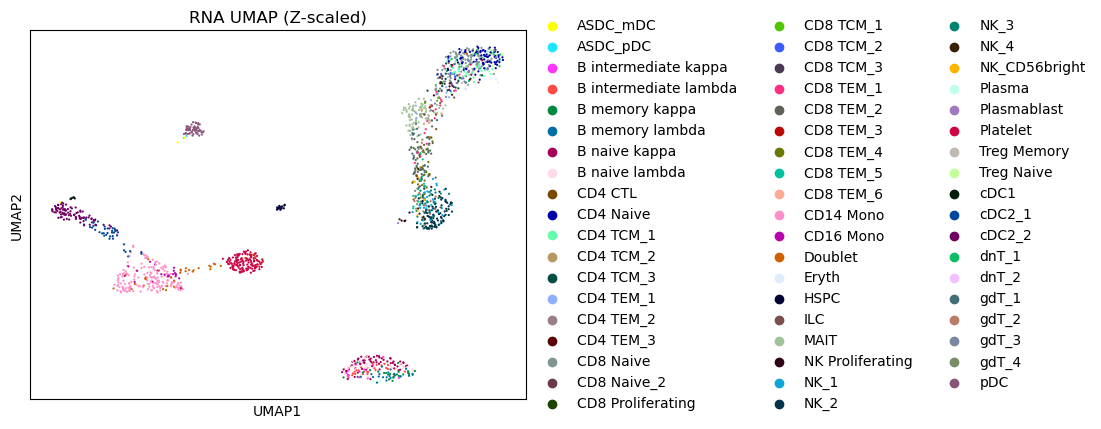

In [40]:
sc.pl.umap(
    for_rna_umap,
    color="celltype.l3",  # or whatever key you want
    size=10,
    title="RNA UMAP (Z-scaled)",
)


In [43]:
print(for_adt_umap)
print(for_adt_umap.X.min())
print(for_adt_umap.X.max())

for_adt_umap.layers['scaled'] = for_adt_umap.X


AnnData object with n_obs × n_vars = 1600 × 228
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'univi_split'
    var: 'features'
    uns: 'log1p'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'stored_norm', 'counts', 'clr', 'clr_scaled'
-7.111670856993268
10.684459110634716


In [44]:
# =========================
# 2) ADT: UMAP from adt_adata.layers['log1p']
# =========================

print("ADT shape:", for_adt_umap.shape)

# Make a shallow copy for PCA so we don't touch the original adt_adata.X
adt_pca = for_adt_umap.copy()

# Use the Z-scaled CLR-normed layer as X for PCA
adt_pca.X = for_adt_umap.layers["scaled"].copy()

# Run PCA on the log1p data
sc.tl.pca(adt_pca, n_comps=50)

# Copy the PCA results back to the original ADT object
for_adt_umap.obsm["X_pca"] = adt_pca.obsm["X_pca"]
for_adt_umap.varm["PCs"]   = adt_pca.varm["PCs"]

# ---- clear any old neighbors graph to avoid 'n_neighbors' KeyError ----
if "neighbors" in for_adt_umap.uns:
    del for_adt_umap.uns["neighbors"]

for k in ["distances", "connectivities"]:
    if k in for_adt_umap.obsp:
        del for_adt_umap.obsp[k]

# ---- recompute neighbors / UMAP using the PCA embedding ----
sc.pp.neighbors(
    for_adt_umap,
    use_rep="X_pca",   # use the PCA we just computed
    n_neighbors=30,    # neighbors (NOT n_pcs) – adjust if you like
    metric="cosine",
)
sc.tl.umap(for_adt_umap)


ADT shape: (1600, 228)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


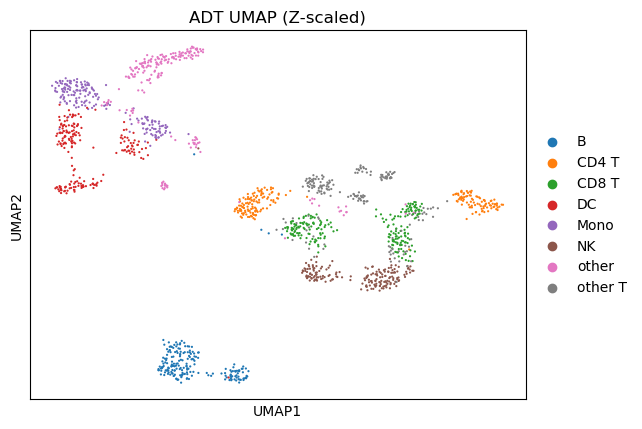

In [45]:
sc.pl.umap(
    for_adt_umap,
    color="celltype.l1",  # or whatever key you want
    size=10,
    title="ADT UMAP (Z-scaled)",
)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


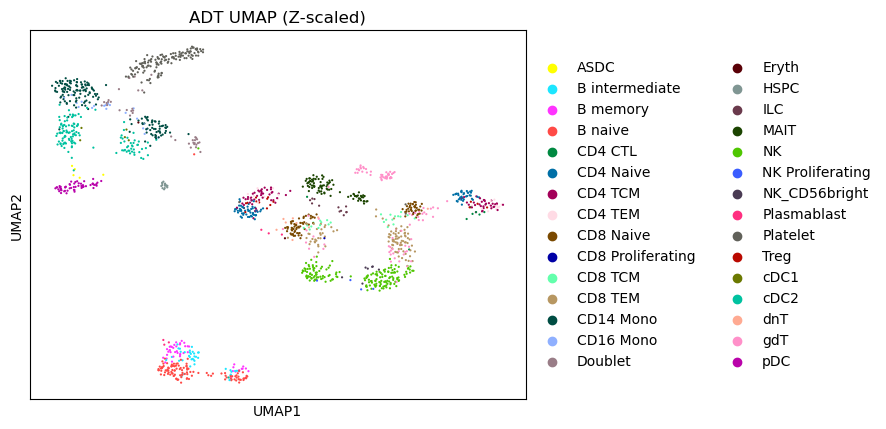

In [46]:
sc.pl.umap(
    for_adt_umap,
    color="celltype.l2",  # or whatever key you want
    size=10,
    title="ADT UMAP (Z-scaled)",
)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


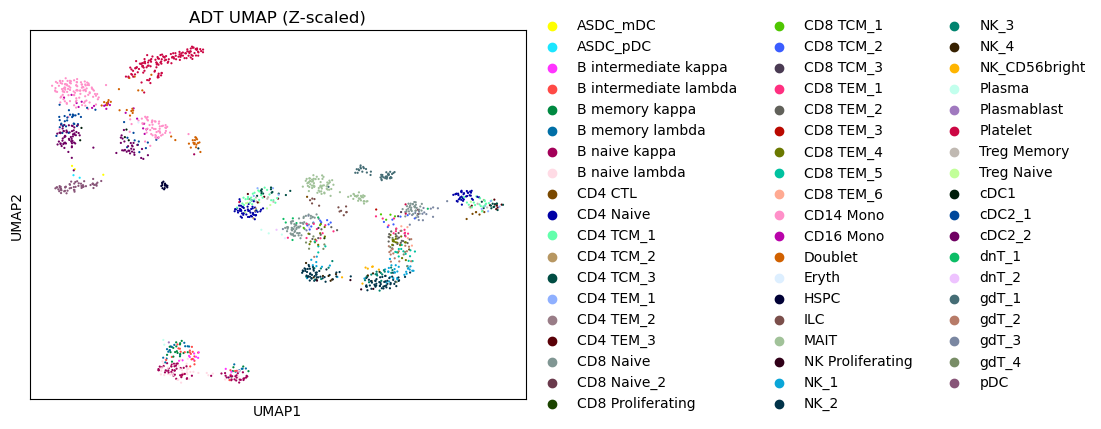

In [47]:
sc.pl.umap(
    for_adt_umap,
    color="celltype.l3",  # or whatever key you want
    size=10,
    title="ADT UMAP (Z-scaled)",
)


In [48]:
print("Modalities in univi_cfg:")
for m in univi_cfg.modalities:
    print(" ", m)

print("Number of modalities:", len(univi_cfg.modalities))


Modalities in univi_cfg:
  ModalityConfig(name='rna', input_dim=2000, encoder_hidden=[512, 256], decoder_hidden=[512, 256], likelihood='gaussian')
  ModalityConfig(name='adt', input_dim=228, encoder_hidden=[256, 128], decoder_hidden=[256, 128], likelihood='gaussian')
Number of modalities: 2


In [49]:
# -------------------------
# 7. Instantiate model + trainer
# -------------------------
model = UniVIMultiModalVAE(univi_cfg).to(train_cfg.device)

trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=train_cfg.device,
)


[2025-11-19 11:37:57,741] [UniVITrainer] [INFO] TrainingConfig:
[2025-11-19 11:37:57,743] [UniVITrainer] [INFO]   n_epochs: 200
[2025-11-19 11:37:57,745] [UniVITrainer] [INFO]   batch_size: 256
[2025-11-19 11:37:57,746] [UniVITrainer] [INFO]   lr: 0.001
[2025-11-19 11:37:57,748] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2025-11-19 11:37:57,749] [UniVITrainer] [INFO]   device: cpu
[2025-11-19 11:37:57,751] [UniVITrainer] [INFO]   log_every: 10
[2025-11-19 11:37:57,752] [UniVITrainer] [INFO]   grad_clip: 5.0
[2025-11-19 11:37:57,754] [UniVITrainer] [INFO]   num_workers: 0
[2025-11-19 11:37:57,755] [UniVITrainer] [INFO]   seed: 42
[2025-11-19 11:37:57,756] [UniVITrainer] [INFO]   early_stopping: True
[2025-11-19 11:37:57,758] [UniVITrainer] [INFO]   patience: 20
[2025-11-19 11:37:57,759] [UniVITrainer] [INFO]   min_delta: 0.0


#### Train model

In [50]:
# -------------------------
# 8. Train!
# -------------------------
history = trainer.fit()


Training UniVI:   0%|          | 0/200 [00:00<?, ?it/s]

[2025-11-19 11:43:44,801] [UniVITrainer] [INFO] [Epoch 001] Train loss: 3715.3724 (beta=0.000, gamma=0.000)
[2025-11-19 11:43:53,221] [UniVITrainer] [INFO] [Epoch 001] Val loss: 3326.0291 (beta=0.000, gamma=0.000)
[2025-11-19 11:43:53,365] [UniVITrainer] [INFO] [Epoch 001] New best val loss: 3326.0291
[2025-11-19 11:49:22,687] [UniVITrainer] [INFO] [Epoch 002] New best val loss: 3179.6791
[2025-11-19 11:55:04,612] [UniVITrainer] [INFO] [Epoch 003] New best val loss: 3135.5535
[2025-11-19 12:01:21,829] [UniVITrainer] [INFO] [Epoch 004] New best val loss: 3095.6303
[2025-11-19 12:07:23,100] [UniVITrainer] [INFO] [Epoch 005] New best val loss: 3084.6737
[2025-11-19 12:37:01,416] [UniVITrainer] [INFO] [Epoch 010] Train loss: 3356.8972 (beta=12.500, gamma=15.000)
[2025-11-19 12:37:11,056] [UniVITrainer] [INFO] [Epoch 010] Val loss: 3238.1042 (beta=12.500, gamma=15.000)
[2025-11-19 13:29:56,515] [UniVITrainer] [INFO] [Epoch 020] Train loss: 3407.9775 (beta=37.500, gamma=45.000)
[2025-11-19 1

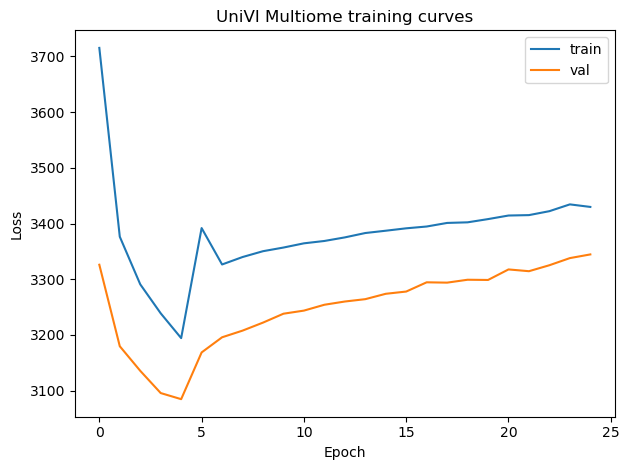

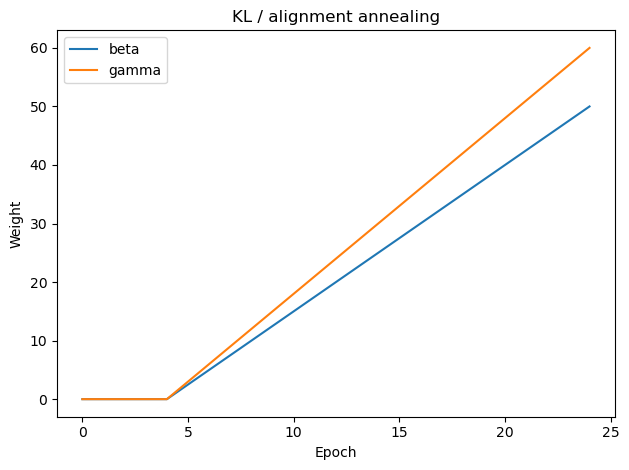

In [51]:
# Quick training curves
fig, ax = plt.subplots()
ax.plot(history["train_loss"], label="train")
ax.plot(history["val_loss"], label="val")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("UniVI Multiome training curves")
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.plot(history["beta"], label="beta")
ax.plot(history["gamma"], label="gamma")
ax.set_xlabel("Epoch")
ax.set_ylabel("Weight")
ax.set_title("KL / alignment annealing")
ax.legend()
plt.tight_layout()
plt.show()


In [52]:
from dataclasses import asdict

os.makedirs("../saved_models", exist_ok=True)

# after training
#history = trainer.fit()

# trainer.model already has the best weights (because we restored best_state_dict)
ckpt_path = "../saved_models/univi_hao_level1_celltype_2k_cap_beta_100_gamma_120_40_hidden_dims_gaussian_decoders_both.pt"
torch.save(
    {
        "state_dict": trainer.model.state_dict(),
        "univi_cfg": asdict(univi_cfg),
        "best_epoch": trainer.best_epoch,
        "best_val_loss": trainer.best_val_loss,
    },
    ckpt_path,
)
print("Saved best model to:", ckpt_path)


Saved best model to: ../saved_models/univi_hao_level1_celltype_2k_cap_beta_100_gamma_120_40_hidden_dims_gaussian_decoders_both.pt


In [53]:
# Later to reload model
'''
import torch
from univi.config import UniVIConfig, ModalityConfig
from univi.models.univi import UniVIMultiModalVAE

device = "cpu"  # or "cuda" if available

ckpt = torch.load(
    #"../saved_models/univi_hao_level2_celltype_1k_cap_beta_20_gamma_80.pt",
    #"../saved_models/univi_hao_level2_celltype_1k_cap_beta_80_gamma_120.pt",
    "../saved_models/univi_hao_level1_celltype_2k_cap_beta_100_gamma_120_40_hidden_dims_gaussian_decoders_both.pt",
    map_location=device,
)

# ---- Rebuild UniVIConfig, making sure modalities are ModalityConfig objects ----
cfg_dict = ckpt["univi_cfg"]

# If this is an OmegaConf object or similar, make sure it's a plain dict
try:
    from omegaconf import DictConfig, OmegaConf
    if isinstance(cfg_dict, DictConfig):
        cfg_dict = OmegaConf.to_container(cfg_dict, resolve=True)
except ImportError:
    pass

# Now rehydrate each modality
modalities = [ModalityConfig(**m) for m in cfg_dict["modalities"]]
cfg_dict = {**cfg_dict, "modalities": modalities}

univi_cfg_loaded = UniVIConfig(**cfg_dict)

# ---- Rebuild model + load weights ----
model_loaded = UniVIMultiModalVAE(univi_cfg_loaded).to(device)
model_loaded.load_state_dict(ckpt["state_dict"])

print("Best epoch was:", ckpt.get("best_epoch"), "val loss =", ckpt.get("best_val_loss"))
'''


'\nimport torch\nfrom univi.config import UniVIConfig, ModalityConfig\nfrom univi.models.univi import UniVIMultiModalVAE\n\ndevice = "cpu"  # or "cuda" if available\n\nckpt = torch.load(\n    #"../saved_models/univi_hao_level2_celltype_1k_cap_beta_20_gamma_80.pt",\n    #"../saved_models/univi_hao_level2_celltype_1k_cap_beta_80_gamma_120.pt",\n    "../saved_models/univi_hao_level1_celltype_2k_cap_beta_100_gamma_120_40_hidden_dims_gaussian_decoders_both.pt",\n    map_location=device,\n)\n\n# ---- Rebuild UniVIConfig, making sure modalities are ModalityConfig objects ----\ncfg_dict = ckpt["univi_cfg"]\n\n# If this is an OmegaConf object or similar, make sure it\'s a plain dict\ntry:\n    from omegaconf import DictConfig, OmegaConf\n    if isinstance(cfg_dict, DictConfig):\n        cfg_dict = OmegaConf.to_container(cfg_dict, resolve=True)\nexcept ImportError:\n    pass\n\n# Now rehydrate each modality\nmodalities = [ModalityConfig(**m) for m in cfg_dict["modalities"]]\ncfg_dict = {**cfg_di

#### Evaluate model

FOSCTTM (rna vs adt): 0.2526
Modality mixing score (k=20): 0.000
Label transfer accuracy (ADT → RNA, k=15): 0.381


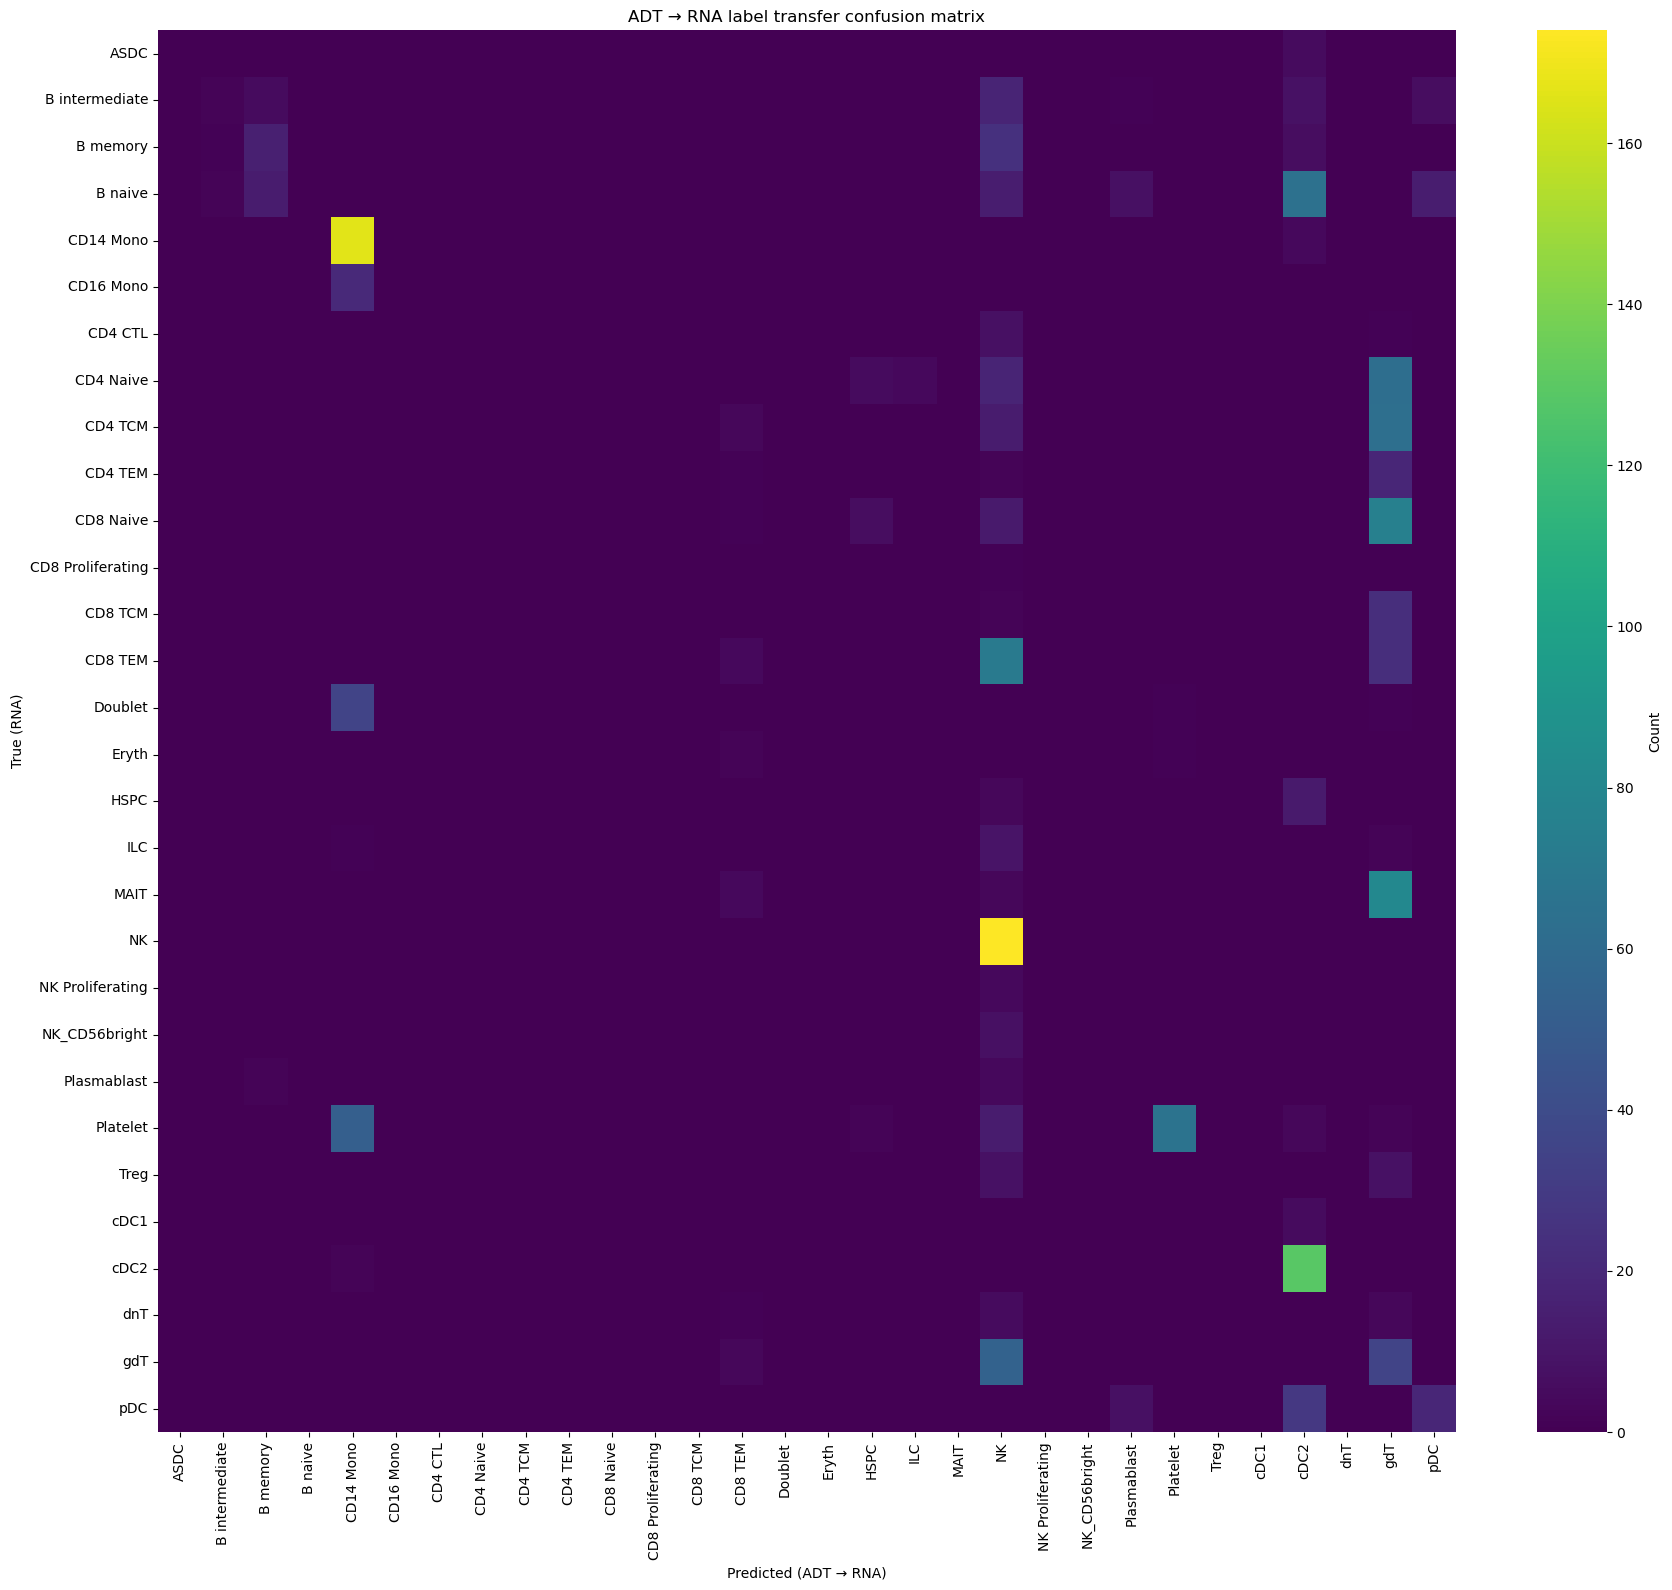

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/

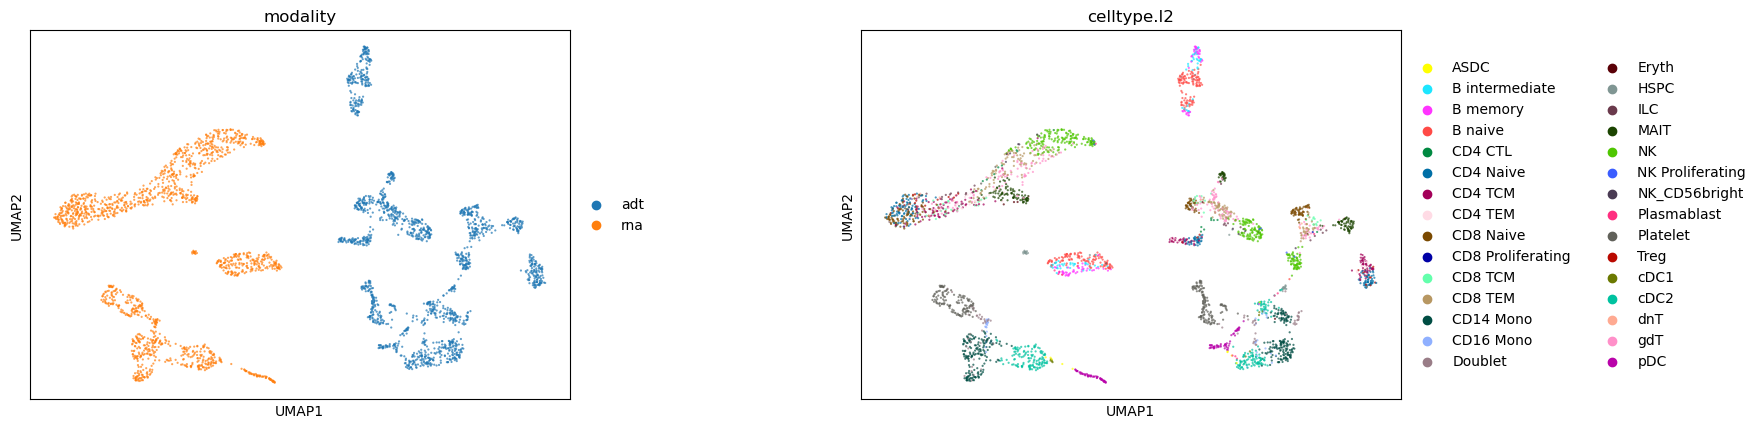

Mean ADT MSE (RNA→ADT): 0.9392
Mean ADT Pearson r (RNA→ADT): 0.350


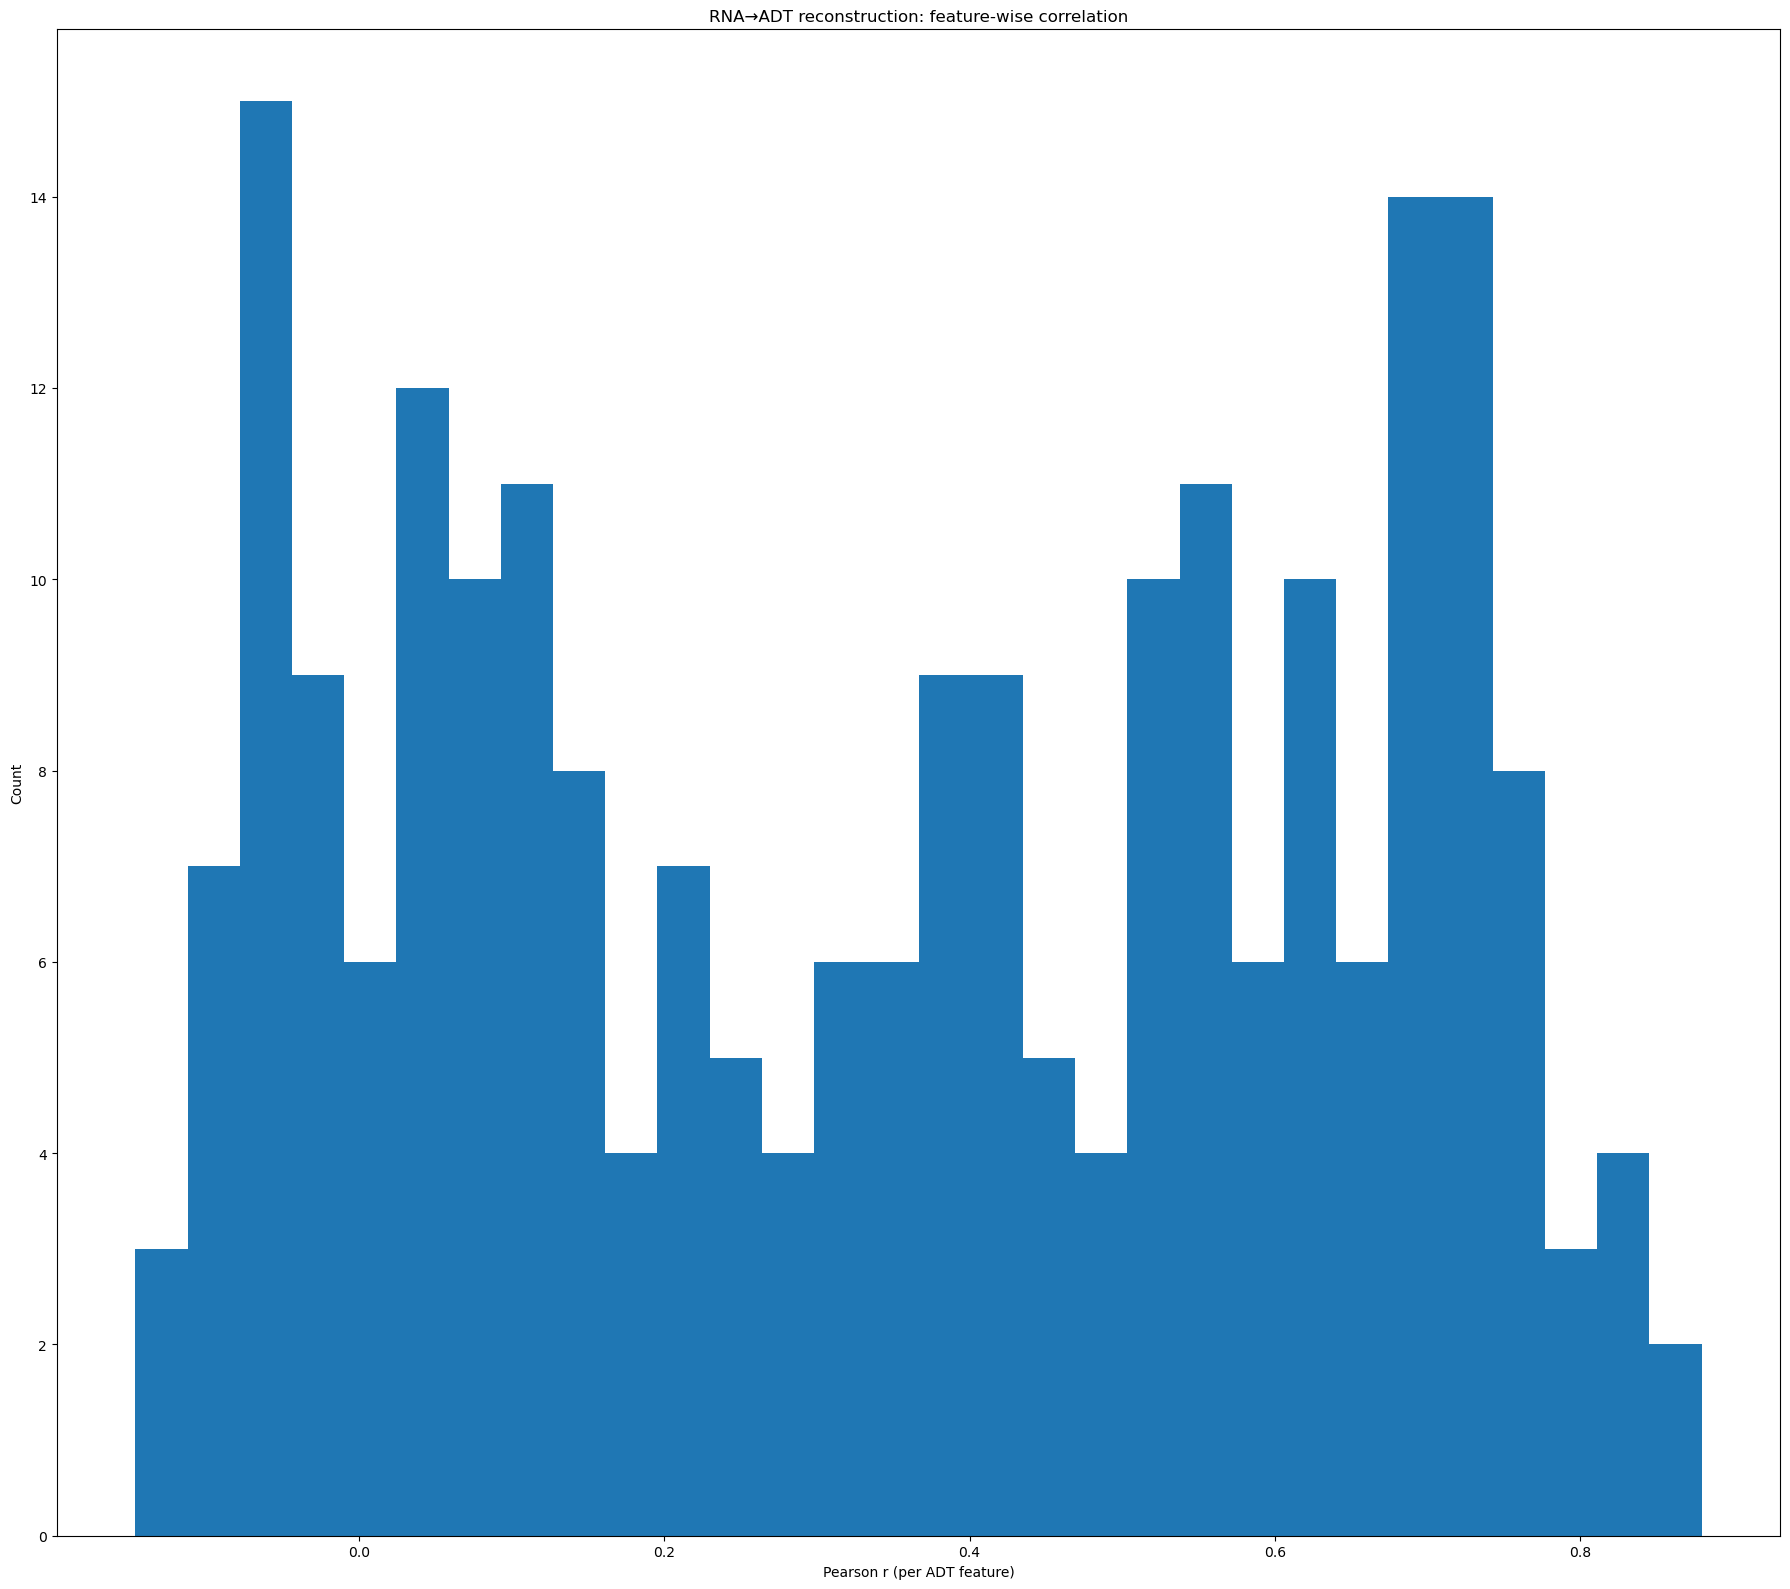

In [54]:
# Previous code results! Beta: 20, Gamma: 80
'''
FOSCTTM (rna vs adt): 0.0995
Modality mixing score (k=20): 0.056
Label transfer accuracy (ADT → RNA, k=15): 0.543
Mean ADT MSE (RNA→ADT): 4224.1214
Mean ADT Pearson r (RNA→ADT): 0.502
'''

# Previous code results! Beta: 80, Gamma: 120
'''
FOSCTTM (rna vs adt): 0.0340
Modality mixing score (k=20): 0.282
Label transfer accuracy (ADT → RNA, k=15): 0.566
Mean ADT MSE (RNA→ADT): 12781.6353
Mean ADT Pearson r (RNA→ADT): 0.369
'''

import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval
# from univi import plotting as univi_plot  # only needed if you still want their saver

# -------------------------
# 1. Encode latent embeddings
# -------------------------
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# -------------------------
# 2. FOSCTTM (global alignment)
# -------------------------
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# -------------------------
# 3. Modality mixing in joint embedding
# -------------------------
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# -------------------------
# 4. Label transfer (ADT → RNA)
# -------------------------
labels_rna = rna_test_adata.obs["celltype.l2"].astype(str).values
labels_adt = adt_test_adata.obs["celltype.l2"].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt,
    Z_target=z_rna,
    labels_target=labels_rna,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

# -------------------------
# 4a. Confusion matrix plot (show)
# -------------------------
uniq_labels = np.unique(labels_rna)

plt.figure(figsize=(18, 16))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: also save with univi_plot if you like
# from univi import plotting as univi_plot
# univi_plot.plot_confusion_matrix(
#     cm_rna,
#     labels=uniq_labels,
#     title="ADT → RNA label transfer",
#     savepath="../figures/citeseq_univi_label_transfer_cm.png",
# )

# -------------------------
# 5. UMAP visualization (biological structure)
#    on the UniVI latent space
# -------------------------

# Make copies and tag modality
rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()
rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

# Concatenate
combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

# Ensure stacked X_univi matches the concat order
combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

# Neighbors/UMAP on UniVI embedding
sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# Show UMAP with two panels: modality and celltype.l2
sc.pl.umap(
    combined,
    color=["modality", "celltype.l2"],
    wspace=0.4,
    size=10,
    alpha=0.7,
    show=True,
)

# Optional: save figure via scanpy
# sc.pl.umap(
#     combined,
#     color=["modality", "celltype.l2"],
#     wspace=0.4,
#     size=10,
#     alpha=0.7,
#     save="_citeseq_univi_umap.png",
# )

# -------------------------
# 6. Optional: cross-modal reconstruction metrics (RNA → ADT)
# -------------------------
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

# compare to observed ADT
X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

# -------------------------
# 6a. Histogram of feature-wise Pearson r
# -------------------------
plt.figure(figsize=(18, 16))
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")
plt.tight_layout()
plt.show()



Test cells: 1600
FOSCTTM (rna vs adt): 0.2526
Modality mixing score (k=20): 0.000
Label transfer accuracy (ADT → RNA, k=15): 0.525


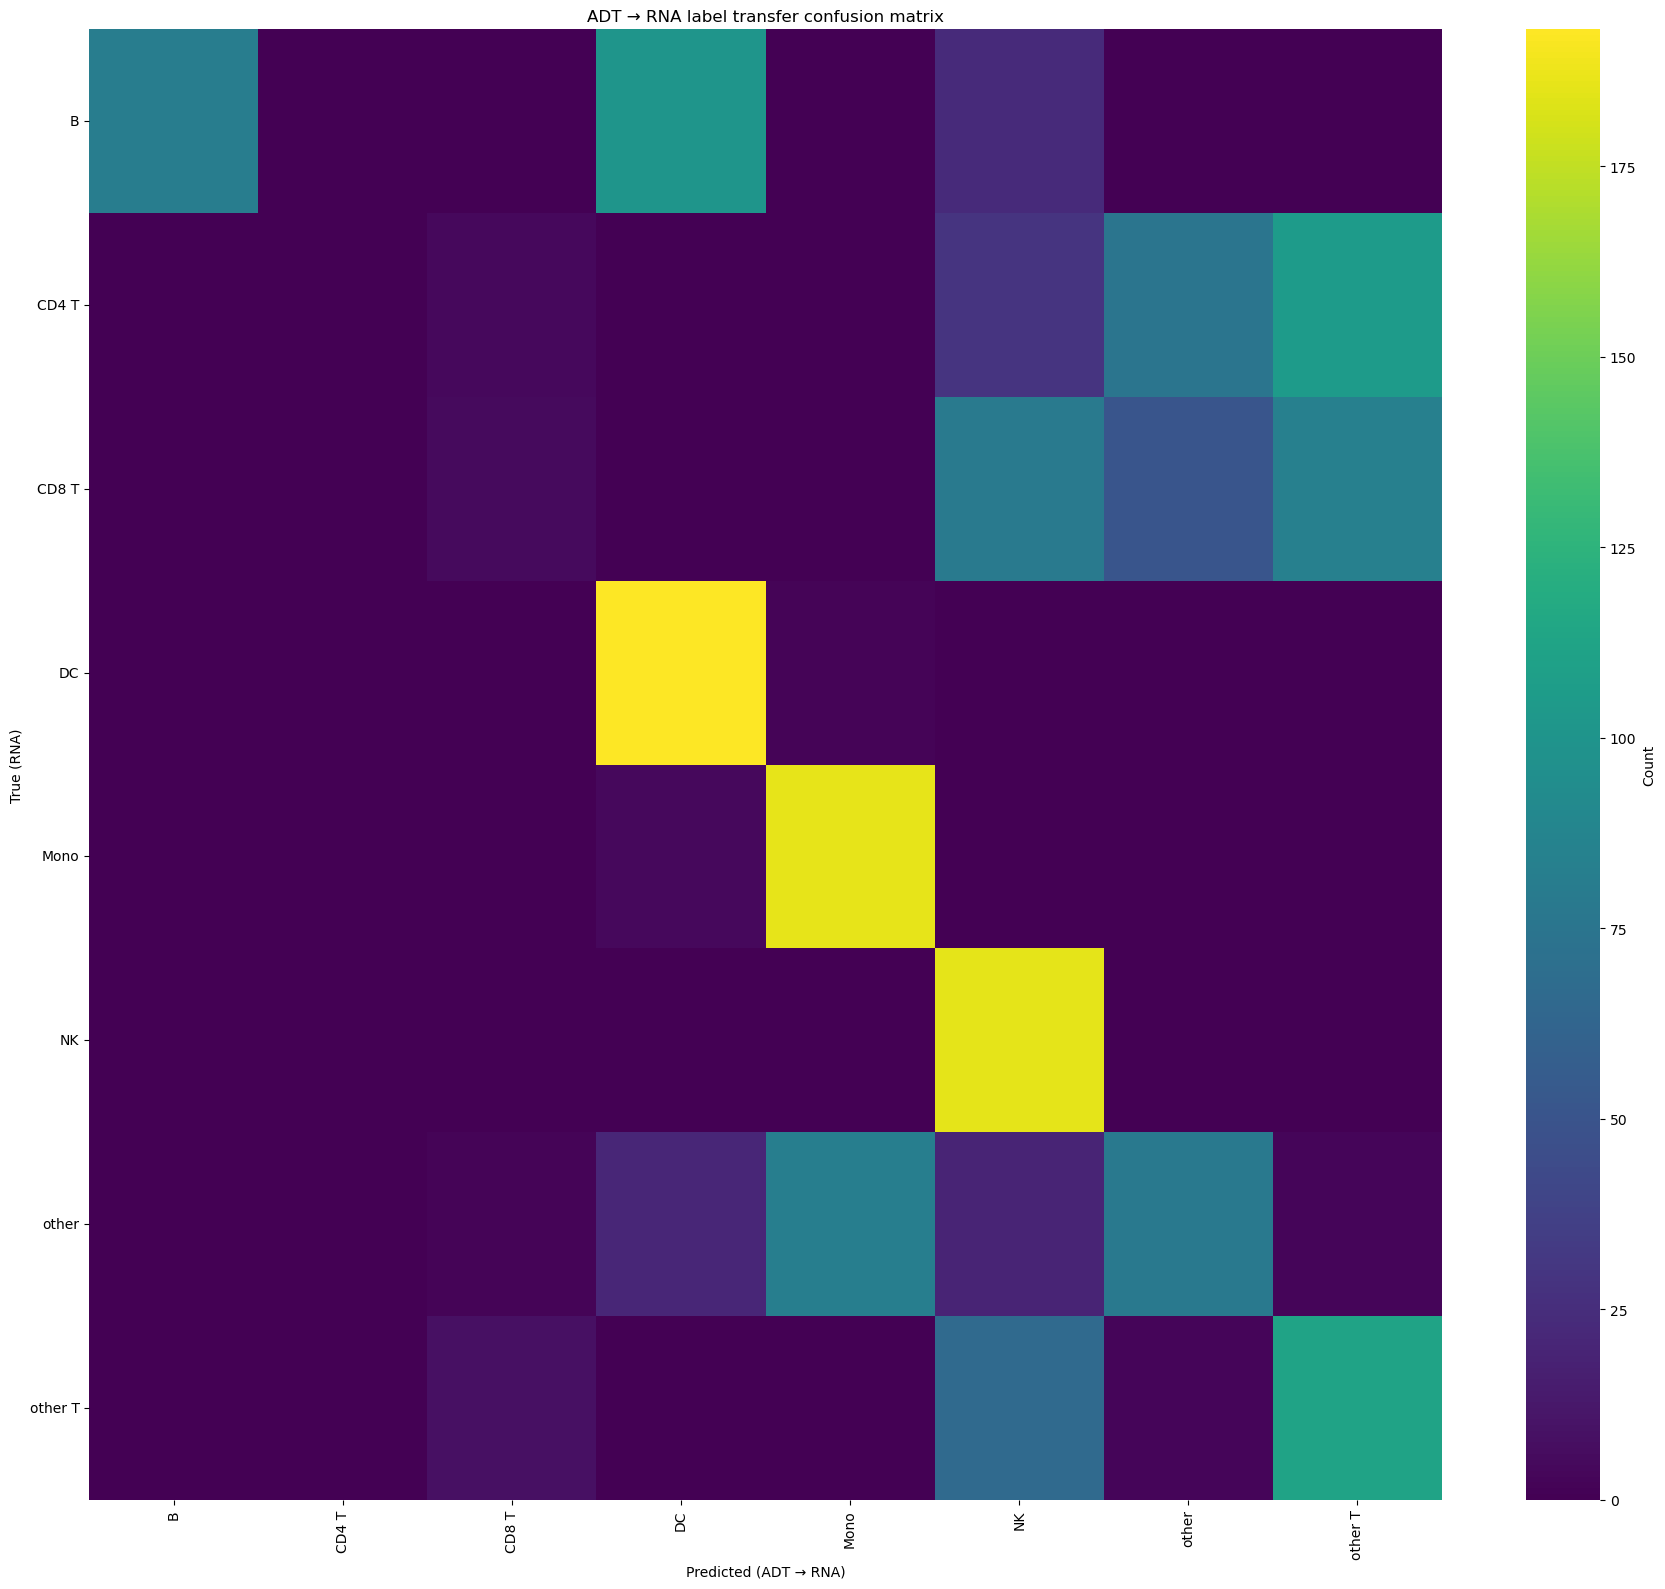

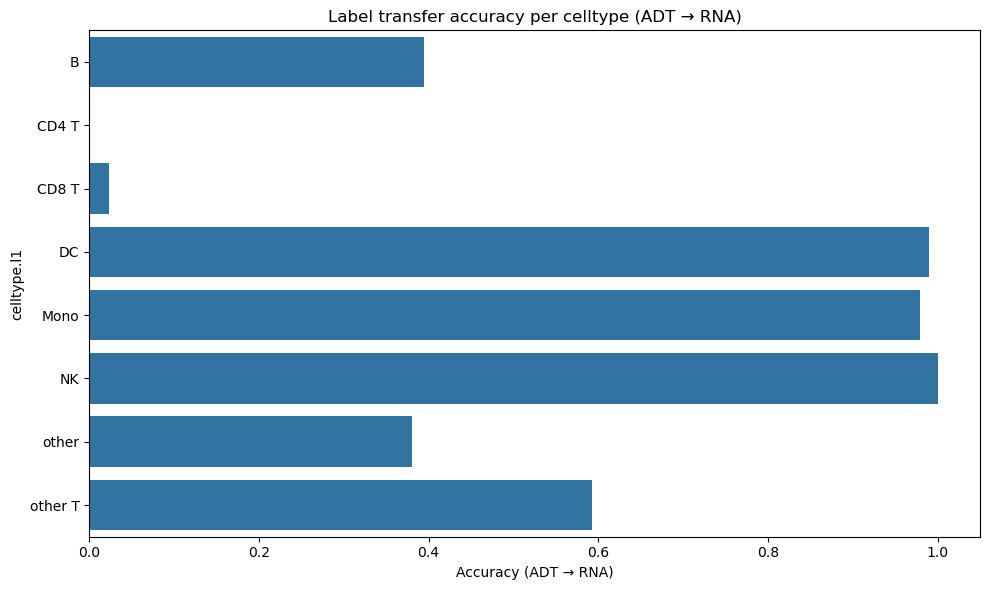

Label transfer accuracy (RNA → ADT, k=15): 0.491
Symmetric label transfer (mean ACC): 0.508


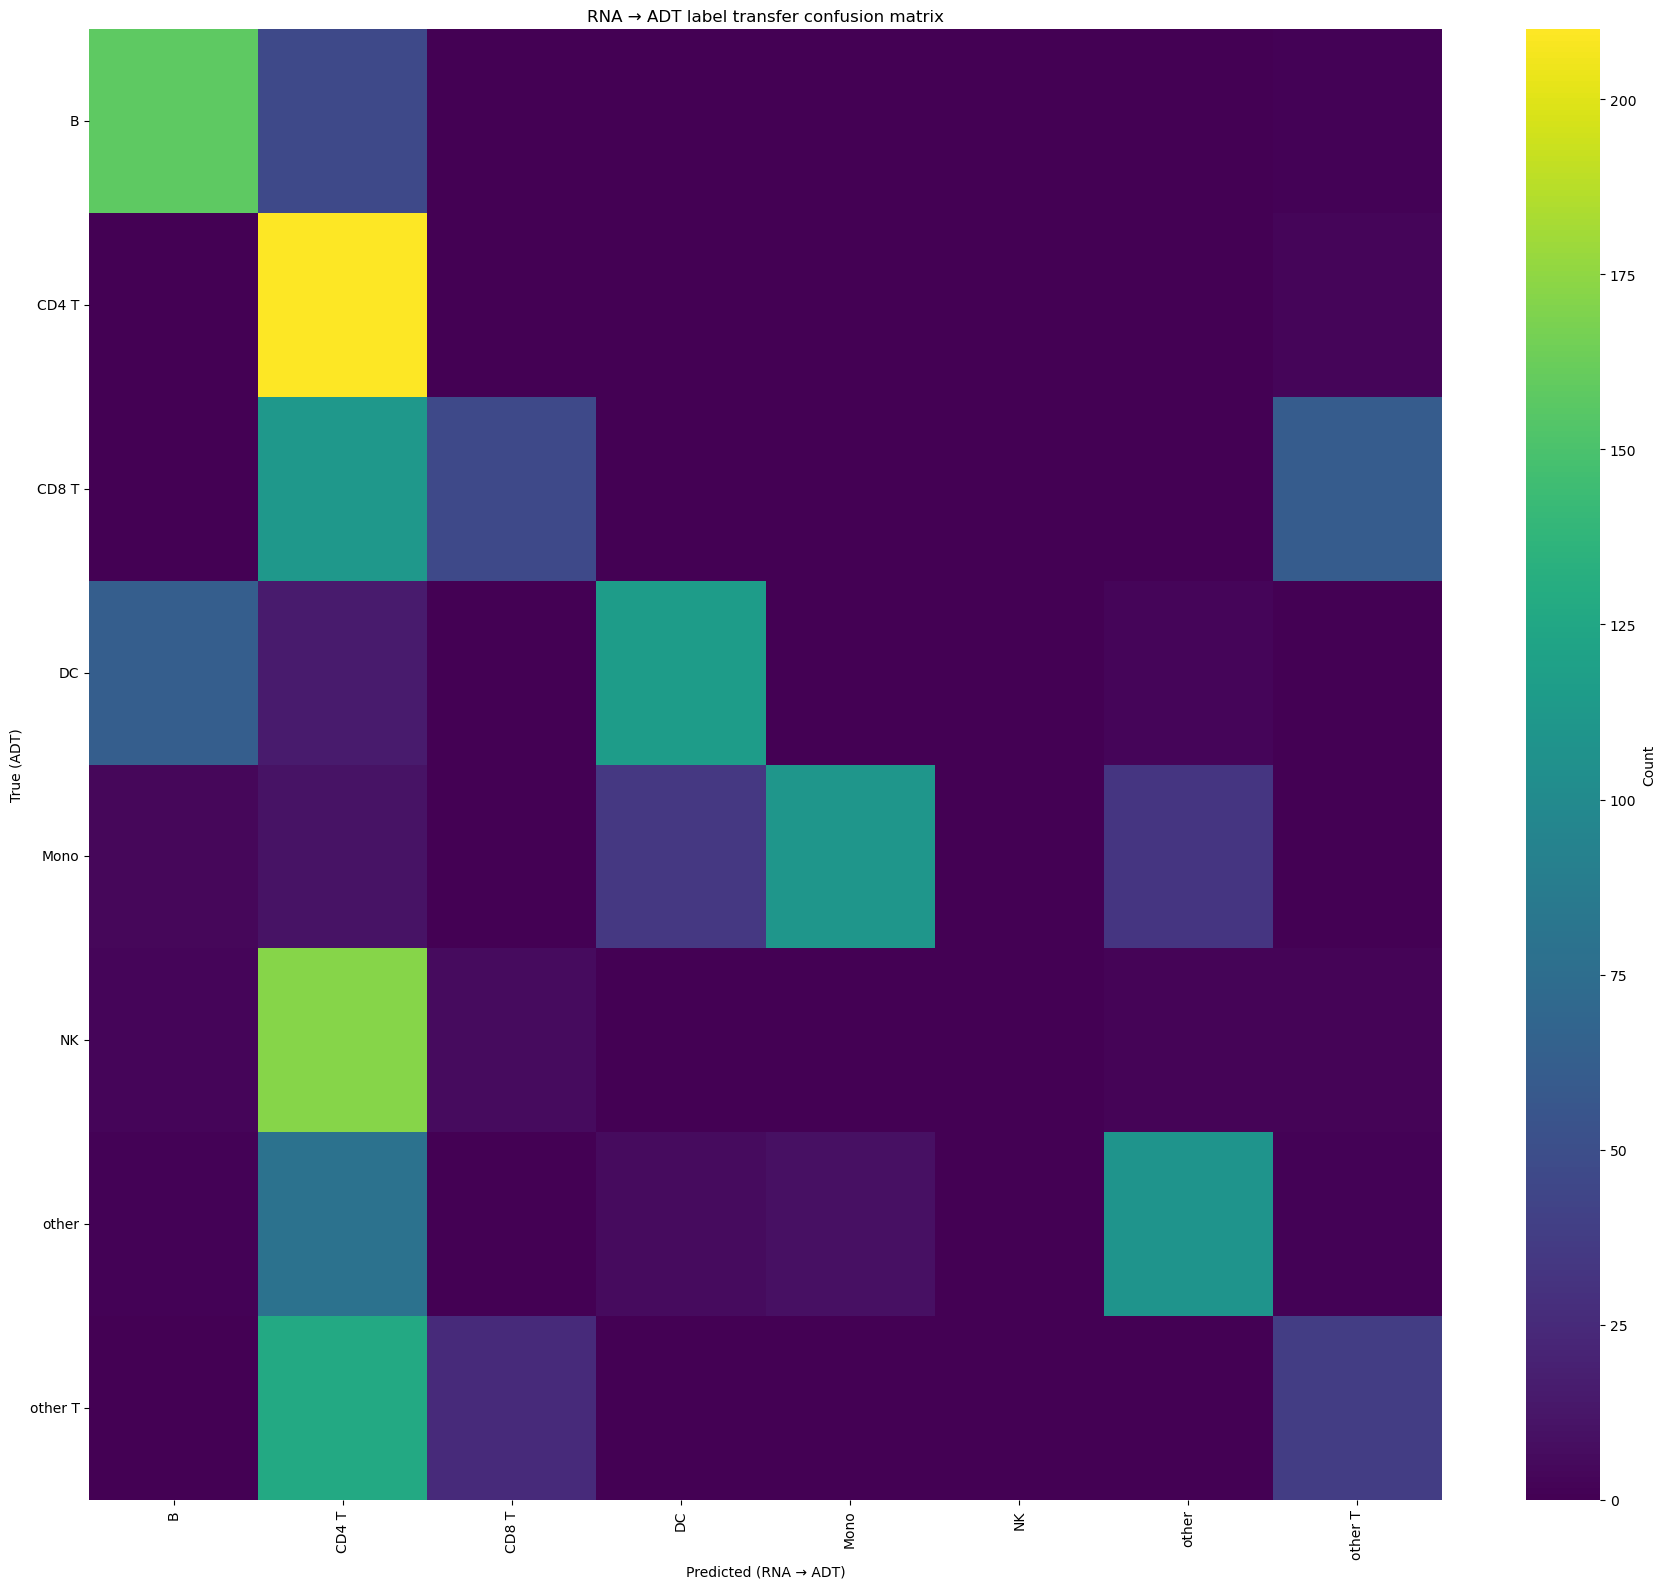

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/

In [ ]:
# New eval code!
import numpy as np
import torch
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from univi import evaluation as univi_eval

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
    accuracy_score,
)
from sklearn.neighbors import NearestNeighbors

# Which celltype resolution to use?
celltype_res = 'celltype.l1'

# ============================================================
# 0. Sanity checks
# ============================================================
assert rna_test_adata.n_obs == adt_test_adata.n_obs, "RNA and ADT TEST sets must have same #cells"
assert np.array_equal(rna_test_adata.obs_names, adt_test_adata.obs_names), (
    "RNA and ADT obs_names must match 1:1 for pairwise metrics."
)

print(f"Test cells: {rna_test_adata.n_obs}")

# ============================================================
# 1. Encode latent embeddings (UniVI)
# ============================================================
z_rna = trainer.encode_modality(rna_test_adata, modality="rna")
z_adt = trainer.encode_modality(adt_test_adata, modality="adt")

rna_test_adata.obsm["X_univi"] = z_rna
adt_test_adata.obsm["X_univi"] = z_adt

# joint embedding for convenience
Z_joint = np.concatenate([z_rna, z_adt], axis=0)
modality_labels = np.array(
    ["rna"] * z_rna.shape[0] + ["adt"] * z_adt.shape[0]
)

# ============================================================
# 2. FOSCTTM (global alignment)
# ============================================================
foscttm = univi_eval.compute_foscttm(z_rna, z_adt)
print(f"FOSCTTM (rna vs adt): {foscttm:.4f}")

# ============================================================
# 3. Modality mixing score (global)
# ============================================================
mixing_score = univi_eval.compute_modality_mixing(
    Z_joint,
    modality_labels,
    k=20,
)
print(f"Modality mixing score (k=20): {mixing_score:.3f}")

# ============================================================
# 4. Label transfer (ADT → RNA) + confusion matrix
# ============================================================
labels_rna_l1 = rna_test_adata.obs[celltype_res].astype(str).values
labels_adt_l1 = adt_test_adata.obs[celltype_res].astype(str).values

pred_rna_from_adt, acc_rna, cm_rna = univi_eval.label_transfer_knn(
    Z_source=z_adt,
    labels_source=labels_adt_l1,
    Z_target=z_rna,
    labels_target=labels_rna_l1,
    k=15,
)

print(f"Label transfer accuracy (ADT → RNA, k=15): {acc_rna:.3f}")

uniq_labels = np.unique(labels_rna_l1)

plt.figure(figsize=(18, 16))
sns.heatmap(
    cm_rna,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (ADT → RNA)")
plt.ylabel("True (RNA)")
plt.title("ADT → RNA label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-celltype accuracy for ADT→RNA
ct_accs = []
for ct in uniq_labels:
    mask = labels_rna_l1 == ct
    if mask.sum() == 0:
        continue
    ct_acc = (pred_rna_from_adt[mask] == labels_rna_l1[mask]).mean()
    ct_accs.append((ct, ct_acc))

ct_names, ct_vals = zip(*ct_accs)

plt.figure(figsize=(10, 6))
sns.barplot(x=ct_vals, y=ct_names, orient="h")
plt.xlabel("Accuracy (ADT → RNA)")
plt.ylabel(celltype_res)
plt.title("Label transfer accuracy per celltype (ADT → RNA)")
plt.tight_layout()
plt.show()

# ============================================================
# 4b. Symmetric label transfer (RNA → ADT) + confusion matrix
# ============================================================
pred_adt_from_rna, acc_adt, cm_adt = univi_eval.label_transfer_knn(
    Z_source=z_rna,
    labels_source=labels_rna_l1,
    Z_target=z_adt,
    labels_target=labels_adt_l1,
    k=15,
)

print(f"Label transfer accuracy (RNA → ADT, k=15): {acc_adt:.3f}")
print(f"Symmetric label transfer (mean ACC): {(acc_rna + acc_adt) / 2:.3f}")

plt.figure(figsize=(18, 16))
sns.heatmap(
    cm_adt,
    annot=False,
    cmap="viridis",
    xticklabels=uniq_labels,
    yticklabels=uniq_labels,
    cbar_kws={"label": "Count"},
)
plt.xlabel("Predicted (RNA → ADT)")
plt.ylabel("True (ADT)")
plt.title("RNA → ADT label transfer confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================
# 5. UMAP visualization on UniVI latent space
# ============================================================

rna_tmp = rna_test_adata.copy()
adt_tmp = adt_test_adata.copy()
rna_tmp.obs["modality"] = "rna"
adt_tmp.obs["modality"] = "adt"

combined = rna_tmp.concatenate(
    adt_tmp,
    join="outer",
    batch_key="concat_batch",
    batch_categories=["rna", "adt"],
    index_unique=None,
)

combined.obsm["X_univi"] = np.vstack([
    rna_test_adata.obsm["X_univi"],
    adt_test_adata.obsm["X_univi"],
])

sc.pp.neighbors(combined, use_rep="X_univi", n_neighbors=30)
sc.tl.umap(combined)

# base UMAP panels: modality + celltype.l1 (+ celltype.l2 if present)
umap_colors = ["modality", "celltype.l1"]
if "celltype.l2" in combined.obs.columns:
    umap_colors.append("celltype.l2")
if "celltype.l3" in combined.obs.columns:
    umap_colors.append("celltype.l3")

sc.pl.umap(
    combined,
    color=umap_colors,
    wspace=0.4,
    size=8,
    alpha=0.7,
    show=True,
)

# ============================================================
# 6. Clustering quality: Leiden on UniVI + ARI / NMI
# ============================================================
sc.tl.leiden(combined, key_added="leiden_univi", resolution=1.0)

labels_true = combined.obs[celltype_res].astype(str)
clusters = combined.obs[celltype_res].astype(str)

mask_valid = labels_true.notna()
ari = adjusted_rand_score(labels_true[mask_valid], clusters[mask_valid])
nmi = normalized_mutual_info_score(labels_true[mask_valid], clusters[mask_valid])

print(f"Leiden vs " + celltype_Res + " ARI: {ari:.3f}")
print(f"Leiden vs " + celltype_res + " NMI: {nmi:.3f}")

# UMAP with Leiden clusters
sc.pl.umap(
    combined,
    color=["leiden_univi"],
    size=8,
    alpha=0.7,
    show=True,
)

# ============================================================
# 7. Silhouette scores (celltype vs modality)
# ============================================================
Z_for_sil = combined.obsm["X_univi"]
n_cells = combined.n_obs
max_cells_for_sil = 20000

rng = np.random.default_rng(0)
if n_cells > max_cells_for_sil:
    idx_sil = rng.choice(n_cells, size=max_cells_for_sil, replace=False)
    Z_sil = Z_for_sil[idx_sil]
    labels_ct_sil = combined.obs[celltype_res].astype(str).values[idx_sil]
    modality_sil = combined.obs["modality"].astype(str).values[idx_sil]
else:
    idx_sil = np.arange(n_cells)
    Z_sil = Z_for_sil
    labels_ct_sil = combined.obs[celltype_res].astype(str).values
    modality_sil = combined.obs["modality"].astype(str).values

# sometimes silhouette fails if only 1 class; guard a bit
unique_ct_sil = np.unique(labels_ct_sil)
if len(unique_ct_sil) > 1:
    sil_celltype = silhouette_score(Z_sil, labels_ct_sil)
else:
    sil_celltype = np.nan

unique_mod_sil = np.unique(modality_sil)
if len(unique_mod_sil) > 1:
    sil_modality = silhouette_score(Z_sil, modality_sil)
else:
    sil_modality = np.nan

print(f"Silhouette (" + celltype_res + ") on UniVI latent: {sil_celltype:.3f}")
print(f"Silhouette (modality) on UniVI latent:   {sil_modality:.3f}  (lower is better for mixing)")

# ============================================================
# 8. Neighborhood label purity + modality entropy
# ============================================================
# kNN in UniVI space
n_neighbors_local = 20
nn_joint = NearestNeighbors(n_neighbors=n_neighbors_local, metric="euclidean")
nn_joint.fit(Z_for_sil)
dist_joint, idx_joint = nn_joint.kneighbors(Z_for_sil)

labels_ct = combined.obs[celltype_res].astype(str).values
mods = combined.obs["modality"].astype(str).values

local_label_purity = []
local_modality_entropy = []

for i in range(Z_for_sil.shape[0]):
    neigh = idx_joint[i, 1:]  # exclude self at [0]
    neigh_ct = labels_ct[neigh]
    neigh_mod = mods[neigh]

    # label purity
    purity = (neigh_ct == labels_ct[i]).mean()
    local_label_purity.append(purity)

    # modality entropy (2-modal max=1 bit)
    p_rna = (neigh_mod == "rna").mean()
    p_adt = 1.0 - p_rna
    entropy = 0.0
    for p in [p_rna, p_adt]:
        if p > 0:
            entropy -= p * np.log2(p)
    local_modality_entropy.append(entropy)

local_label_purity = np.asarray(local_label_purity)
local_modality_entropy = np.asarray(local_modality_entropy)

combined.obs["local_label_purity"] = local_label_purity
combined.obs["local_modality_entropy"] = local_modality_entropy

print(f"Mean local label purity (k={n_neighbors_local}): {local_label_purity.mean():.3f}")
for m in ["rna", "adt"]:
    mask_m = (mods == m)
    print(f"  {m} mean local label purity: {local_label_purity[mask_m].mean():.3f}")

print(f"Mean local modality entropy (k={n_neighbors_local}): {local_modality_entropy.mean():.3f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(local_label_purity, bins=30)
plt.xlabel("Local label purity")
plt.ylabel("Cells")
plt.title("kNN label purity")

plt.subplot(1, 2, 2)
plt.hist(local_modality_entropy, bins=30)
plt.xlabel("Local modality entropy (bits)")
plt.ylabel("Cells")
plt.title("kNN modality entropy")
plt.tight_layout()
plt.show()

# ============================================================
# 9. Pairwise matching metrics (top-1 / top-5 / top-10)
#    Uses true RNA–ADT pairing via obs_names
# ============================================================
k_match = 10
nn_adt_for_rna = NearestNeighbors(n_neighbors=k_match, metric="euclidean")
nn_adt_for_rna.fit(z_adt)
dist_ra, idx_ra = nn_adt_for_rna.kneighbors(z_rna)

true_idx = np.arange(z_rna.shape[0])
top1_hits = (idx_ra[:, 0] == true_idx)
top5_hits = (idx_ra[:, :5] == true_idx[:, None]).any(axis=1)
top10_hits = (idx_ra[:, :10] == true_idx[:, None]).any(axis=1)

print(f"Pairwise matching (RNA→ADT):")
print(f"  Top-1 accuracy:  {top1_hits.mean():.3f}")
print(f"  Top-5 accuracy:  {top5_hits.mean():.3f}")
print(f"  Top-10 accuracy: {top10_hits.mean():.3f}")

plt.figure(figsize=(6, 4))
plt.bar(
    ["Top-1", "Top-5", "Top-10"],
    [top1_hits.mean(), top5_hits.mean(), top10_hits.mean()],
)
plt.ylabel("Fraction of correctly matched pairs")
plt.title("Cross-modal matching accuracy (RNA→ADT)")
plt.tight_layout()
plt.show()

# ============================================================
# 10. Cross-modal reconstruction metrics (RNA → ADT)
# ============================================================
model.eval()
with torch.no_grad():
    X_rna = rna_test_adata.X
    if sp.issparse(X_rna):
        X_rna = X_rna.toarray()
    X_rna_t = torch.as_tensor(X_rna, dtype=torch.float32, device=trainer.device)

    xhat_adt_list = []
    batch_size = 512
    for start in range(0, X_rna_t.shape[0], batch_size):
        xb = X_rna_t[start:start + batch_size]
        mu_dict, logvar_dict = model.encode_modalities({"rna": xb})
        mu_z, logvar_z = model.mixture_of_experts(mu_dict, logvar_dict)
        xhat_dict = model.decode_modalities(mu_z)
        xhat_adt_list.append(xhat_dict["adt"].cpu().numpy())

    xhat_adt = np.vstack(xhat_adt_list)

X_adt = adt_test_adata.X
if sp.issparse(X_adt):
    X_adt = X_adt.toarray()

mse_feat = univi_eval.mse_per_feature(X_adt, xhat_adt)
corr_feat = univi_eval.pearson_corr_per_feature(X_adt, xhat_adt)

print(f"Mean ADT MSE (RNA→ADT): {mse_feat.mean():.4f}")
print(f"Mean ADT Pearson r (RNA→ADT): {corr_feat.mean():.3f}")

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.hist(corr_feat, bins=30)
plt.xlabel("Pearson r (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise correlation")

plt.subplot(1, 2, 2)
plt.hist(mse_feat, bins=30)
plt.xlabel("MSE (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise MSE")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 10b. Feature-wise R²
# ------------------------------------------------------------
var_true = X_adt.var(axis=0)
# avoid division by 0
var_true[var_true == 0] = np.nan
r2_feat = 1.0 - mse_feat / var_true

print(f"Mean ADT R² (RNA→ADT): {np.nanmean(r2_feat):.3f}")

plt.figure(figsize=(8, 4))
plt.hist(r2_feat[~np.isnan(r2_feat)], bins=30)
plt.xlabel("R² (per ADT feature)")
plt.ylabel("Count")
plt.title("RNA→ADT reconstruction: feature-wise R²")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 10c. Per-cell Pearson r (across ADT features)
# ------------------------------------------------------------
def rowwise_corr(x, y):
    # x, y: (n_cells x n_features)
    x_center = x - x.mean(axis=1, keepdims=True)
    y_center = y - y.mean(axis=1, keepdims=True)
    num = (x_center * y_center).sum(axis=1)
    denom = np.sqrt((x_center**2).sum(axis=1) * (y_center**2).sum(axis=1))
    denom[denom == 0] = np.nan
    return num / denom

cell_corr = rowwise_corr(X_adt, xhat_adt)
print(f"Mean per-cell ADT Pearson r (RNA→ADT): {np.nanmean(cell_corr):.3f}")

plt.figure(figsize=(8, 4))
plt.hist(cell_corr[~np.isnan(cell_corr)], bins=30)
plt.xlabel("Pearson r (per cell, ADT profile)")
plt.ylabel("Cells")
plt.title("RNA→ADT reconstruction: per-cell correlation")
plt.tight_layout()
plt.show()

# Optional: attach to AnnData for later plotting
adt_test_adata.obs["rna2adt_cell_corr"] = cell_corr

# Example: UMAP colored by reconstruction quality
sc.pl.umap(
    combined,
    color=["local_label_purity", "local_modality_entropy"],
    wspace=0.4,
    size=8,
    alpha=0.7,
    show=True,
)


In [ ]:
print(history)


In [ ]:
# Encode new cells to latent embeddings
z_rna = univi_eval.encode_adata(model, rna_unused, modality="rna", device=train_cfg.device)
z_adt = univi_eval.encode_adata(model, adt_unused, modality="adt", device=train_cfg.device)

rna_unused.obsm["X_univi"] = z_rna
adt_unused.obsm["X_univi"] = z_adt


In [ ]:
# Cross modal generation from one modality to another: RNA -> ADT example
Xhat_adt_from_rna = univi_eval.cross_modal_predict(
    model,
    adata_src=rna_unused,
    src_mod="rna",
    tgt_mod="adt",
    device=train_cfg.device,
)


In [ ]:
# Denoising using the decoders
univi_eval.denoise_adata(model, rna_unused, modality="rna", device=train_cfg.device)
univi_eval.denoise_adata(model, adt_unused, modality="adt", device=train_cfg.device)

# you now have rna_test_adata.layers["univi_denoised"] etc.


In [ ]:
'''
celltype.l2
CD14 Mono            42690
CD4 Naive            17479
NK                   17173
CD4 TCM              14889
CD8 TEM              11727
CD8 Naive            10768
B naive               7718
CD16 Mono             6320
CD4 TEM               4282
gdT                   3649
B memory              3285
CD8 TCM               2883
MAIT                  2784
Treg                  2507
cDC2                  2501
B intermediate        2431
Platelet              2293
CD4 CTL               1736
NK_CD56bright          943
pDC                    861
Doublet                605
NK Proliferating       548
Plasmablast            366
dnT                    356
HSPC                   329
cDC1                   151
ILC                    132
CD4 Proliferating      108
CD8 Proliferating       91
Eryth                   83
ASDC                    76
'''

In [ ]:
# Sanity check total l2 celltypes for the unused RNA adata
print(rna_unused)
print(set(rna_unused.obs['celltype.l2']))
print(rna_unused.obs['celltype.l2'].value_counts())


In [ ]:
# Sanity check total l2 celltypes for the unused ADT adata - should be the same as RNA adata above..
print(adt_unused)
print(set(adt_unused.obs['celltype.l2']))
print(adt_unused.obs['celltype.l2'].value_counts())


In [ ]:
# Sampling from the latent space per cell type

# fit per-celltype Gaussians in latent space
labels_rna = rna_unused.obs["celltype.l2"].astype(str).values
Z_rna = rna_unused.obsm["X_univi"]  # from encode_adata earlier

gauss_by_ct = univi_eval.fit_latent_gaussians_by_label(Z_rna, labels_rna)

# define how many samples per cell type
spec = {
    'CD14 Mono': 1000,
    'CD4 Naive': 1000,
    'NK': 1000,
    'CD4 TCM': 1000,
    'CD8 TEM': 1000,
    'CD8 Naive': 1000,
    'B naive': 1000,
    'CD16 Mono': 1000,
    'CD4 TEM': 1000,
    'gdT': 1000,
    'B memory': 1000,
    'CD8 TCM': 1000,
    'MAIT': 1000,
    'Treg': 1000,
    'cDC2': 1000,
    'B intermediate': 1000,
    'Platelet': 1000,
    'CD4 CTL': 1000,
    'NK_CD56bright': 1000,
    'pDC': 1000,
    'Doublet': 1000,
    'NK Proliferating': 1000,
    'Plasmablast': 1000,
    'dnT': 1000,
    'HSPC': 1000,
    'cDC1': 1000,
    'ILC': 1000,
    'CD4 Proliferating': 1000,
    'CD8 Proliferating': 1000,
    'Eryth': 1000,
    'ASDC': 1000,
}

z_samp_by_ct = univi_eval.sample_from_latent_gaussians(gauss_by_ct, spec, random_state=42)

# decode to desired modality
def decode_latent_samples(model, z_samp_by_ct, modality: str, device: str = "cpu"):
    model.eval()
    out = {}
    with torch.no_grad():
        for lab, Z in z_samp_by_ct.items():
            z_t = torch.as_tensor(Z, dtype=torch.float32, device=device)
            xhat_dict = model.decode_modalities(z_t)
            out[lab] = xhat_dict[modality].cpu().numpy()
    return out

synthetic_adt_by_ct = decode_latent_samples(model, z_samp_by_ct, modality="adt", device=train_cfg.device)


In [ ]:
print(synthetic_adt_by_ct)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# -----------------------------
# Build matrix + labels from dict
# -----------------------------
# z_samp_by_ct: dict[celltype -> (n_samples, latent_dim)]
X_list = []
y_list = []

for ct, Z in z_samp_by_ct.items():
    X_list.append(Z)
    y_list.extend([ct] * Z.shape[0])

X = np.vstack(X_list)               # (N_total, latent_dim)
y = np.array(y_list, dtype=str)     # (N_total,)

print("Total synthetic samples:", X.shape[0])
print("Latent dim:", X.shape[1])

# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X)   # (N_total, 2)

# -----------------------------
# Plot colored by cell type
# -----------------------------
plt.figure(figsize=(18, 16))

uniq_cts = np.unique(y)
# use a categorical colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(uniq_cts))

for i, ct in enumerate(uniq_cts):
    idx = (y == ct)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=5,
        alpha=0.6,
        color=cmap(i),
        label=ct,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of synthetic latent samples by cell type")
plt.legend(
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# -----------------------------
# Build matrix + labels from dict
# -----------------------------
# z_samp_by_ct: dict[celltype -> (n_samples, latent_dim)]
X_list = []
y_list = []

for ct, Z in synthetic_adt_by_ct.items():
    X_list.append(Z)
    y_list.extend([ct] * Z.shape[0])

X = np.vstack(X_list)               # (N_total, latent_dim)
y = np.array(y_list, dtype=str)     # (N_total,)

print("Total synthetic samples:", X.shape[0])
print("Decoded dim:", X.shape[1])

# -----------------------------
# UMAP embedding
# -----------------------------
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",
    random_state=42,
)
X_umap = reducer.fit_transform(X)   # (N_total, 2)

# -----------------------------
# Plot colored by cell type
# -----------------------------
plt.figure(figsize=(18, 16))

uniq_cts = np.unique(y)
# use a categorical colormap with enough colors
cmap = plt.cm.get_cmap("tab20", len(uniq_cts))

for i, ct in enumerate(uniq_cts):
    idx = (y == ct)
    plt.scatter(
        X_umap[idx, 0],
        X_umap[idx, 1],
        s=5,
        alpha=0.6,
        color=cmap(i),
        label=ct,
    )

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of synthetic decoded samples by cell type")
plt.legend(
    bbox_to_anchor=(1.05, 1.0),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=8,
    ncol=1,
)
plt.tight_layout()
plt.show()
